## 0. Imports

In [2]:
%load_ext autoreload
%autoreload 2


In [ ]:
# """Installs"""

# !pip install nc-time-axis
# !pip install netCDF4 h5netcdf
# !pip install xarray
# !pip install cdsapi
# !pip install networkx geopandas osmnx igraph matplotlib
# !pip install pysal scikit-learn libpysal tobler geopandas numpy pandas networkx
# !pip install access
# !pip install transliterate


In [ ]:
"""Path handling"""

from pathlib import Path
import sys


# Add parent directory to Python path to enable imports from scripts/
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)


In [ ]:
"""Imports"""

import matplotlib.pyplot as plt
from tqdm import tqdm
import time

import scripts.model.provision as provision

from scripts.calculator.calculator_this_pipeline import make_block_scheme
from scripts.plotter.plotter_transport_mode_prob import (
    plot_transport_probability_legacy,
)
from scripts.calculator.calculator_transport_prob import get_transport_probability
from scripts.preprocesser.preprocesser import get_data
from scripts.preprocesser.gcreator import make_g, add_temp_to_g
from scripts.preprocesser.huston import call_nasa
from scripts.calculator.calculator_stat import create_agglomeration_network
from scripts.calculator.calculator_monthly_mode import create_df_modes_monthly_fixed
from scripts.plotter.plotter_multilayer_service_network import plot_multilayer_network
from scripts.plotter.plotter_flow_sankey import create_clean_sankey
from scripts.plotter.plotter_circular_network_sankey_style import (
    plot_circular_network_sankey_style,
)
from scripts.plotter.plotter_multi_temporal_nx_plots import (
    plot_temporal_service_evolution,
    calculate_temporal_metrics,
    plot_temporal_metrics,
)
from scripts.preprocesser.constants import (
    START_YEAR,
    MONTHS_IN_YEAR,
    CONST_BASE_DEMAND,
    transport_modes,
    transport_modes_color,
    service_radius_minutes,
    transport_mode_name_mapper,
    service_list,
    threshold,
    month_order,
)


tqdm.pandas()


## 1. Transport prob chart [user-defined]

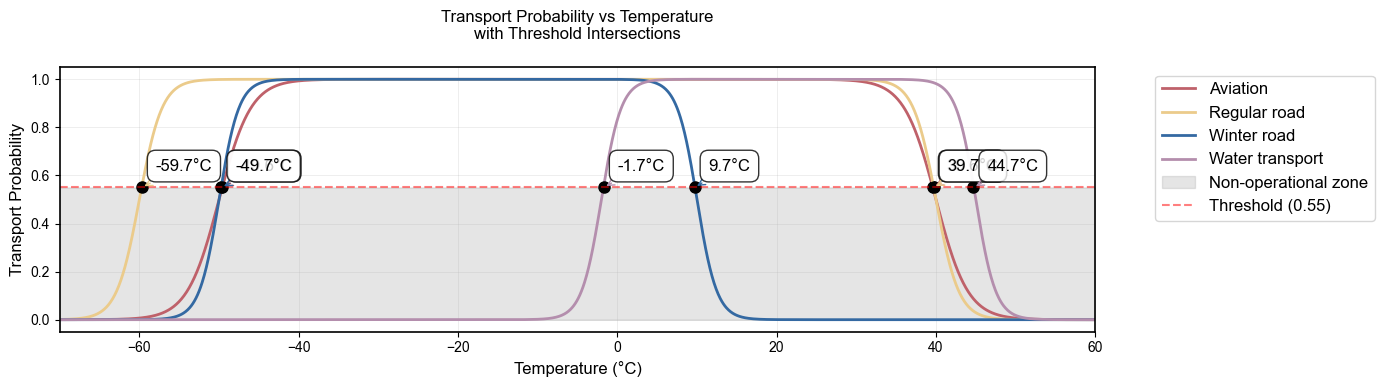

In [6]:
threshold_temperatures = plot_transport_probability_legacy(
    transport_modes,
    transport_modes_color,
    get_transport_probability,
    threshold,
    temps=None,
    font_size=12,
)


## 2. Main calculations

In [7]:
# Store results for each settlement and service
all_results = {}
# yakut_chuk
# yanao_kras
# mezen
# nao

# service_list = ['school']

data_path = "../data/"
settl_name_lst = ["yakut_chuk", "yanao_kras", "mezen", "nao"]
range_months = range(12)  # Starting Jan 1982

for SETTL_NAME in settl_name_lst:
    print("=" * 10, SETTL_NAME, "=" * 10)

    # Initialize settlement results
    all_results[SETTL_NAME] = {}
    # service_list
    for SERVICE_NAME in service_list:
        print(" " * 10, SERVICE_NAME, " " * 10)

        CLIMATE_DATA_FILE_NAME = f"df_climate_{SETTL_NAME}.csv"

        settl, df_service, transport_df, infr_df = get_data(
            data_path,
            SETTL_NAME,
            transport_mode_name_mapper,
            transport_modes,
            SERVICE_NAME,
        )

        blocks_gdf = make_block_scheme(settl, df_service, service_name=SERVICE_NAME)
        G_undirected = make_g(transport_df, transport_modes, blocks_gdf, settl)

        df_monthly_list = call_nasa(blocks_gdf, CLIMATE_DATA_FILE_NAME)
        G_undirected = add_temp_to_g(G_undirected, df_monthly_list)

        net = create_agglomeration_network(
            graph=G_undirected,
            threshold=threshold,
            probability_function=get_transport_probability,
            provision_calculator=provision.calculate_graph_provision,
        )

        net.run_all_steps(
            range_months,
            service_radius_minutes=service_radius_minutes[SETTL_NAME],
            base_demand=CONST_BASE_DEMAND,
            service_name=SERVICE_NAME,
            return_assignment=True,
        )

        # Store results for this service
        all_results[SETTL_NAME][SERVICE_NAME] = {
            "net": net,
            "stats": net.stats,
            "graphs": net.stats.graphs,
            "records": net.stats.records,
            "results": net.stats.results,
            "G_undirected": G_undirected,
        }

        # Предполагаем что индекс df_stats — это месяцы в виде `i` (0...len-1)
        df_stats = net.stats.records
        try:
            df_stats["Month"] = df_stats.index % MONTHS_IN_YEAR + 1
            df_stats["Year"] = START_YEAR + df_stats.index // MONTHS_IN_YEAR
        except Exception:
            pass

        df_modes_monthly = create_df_modes_monthly_fixed(
            G_undirected,
            transport_modes,
            threshold_temperatures,
            START_YEAR,
            MONTHS_IN_YEAR=MONTHS_IN_YEAR,
        )

        # Store df_modes_monthly as well
        all_results[SETTL_NAME][SERVICE_NAME]["df_modes_monthly"] = df_modes_monthly


SETTL_NAME = None
SERVICE_NAME = None


========== yakut_chuk ==========
           post           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  8.58it/s]


           culture           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 16.39it/s]


           health           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 14.86it/s]


           port           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 17.46it/s]


           airport           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 16.78it/s]


           marina           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 17.67it/s]


========== yanao_kras ==========
           post           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  9.22it/s]


           culture           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  9.32it/s]


           health           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00, 10.04it/s]


           port           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  9.46it/s]


           airport           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  9.95it/s]


           marina           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00, 10.51it/s]


========== mezen ==========
           post           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  7.68it/s]


           culture           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  8.75it/s]


           health           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  8.27it/s]


           port           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


           airport           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  7.99it/s]


           marina           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  8.98it/s]


========== nao ==========
           post           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  7.10it/s]


           culture           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  7.07it/s]


           health           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  6.32it/s]


           port           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  7.08it/s]


           airport           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  7.32it/s]


           marina           


Running network analysis: 100%|██████████| 12/12 [00:01<00:00,  7.55it/s]


## 3. Multilayer chart

/Users/test/Documents/code/arctic2/season_framed_multilayer_arctic_network_model/scripts/plotter/plotter_multilayer_service_network.py:172: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  ax.plot(


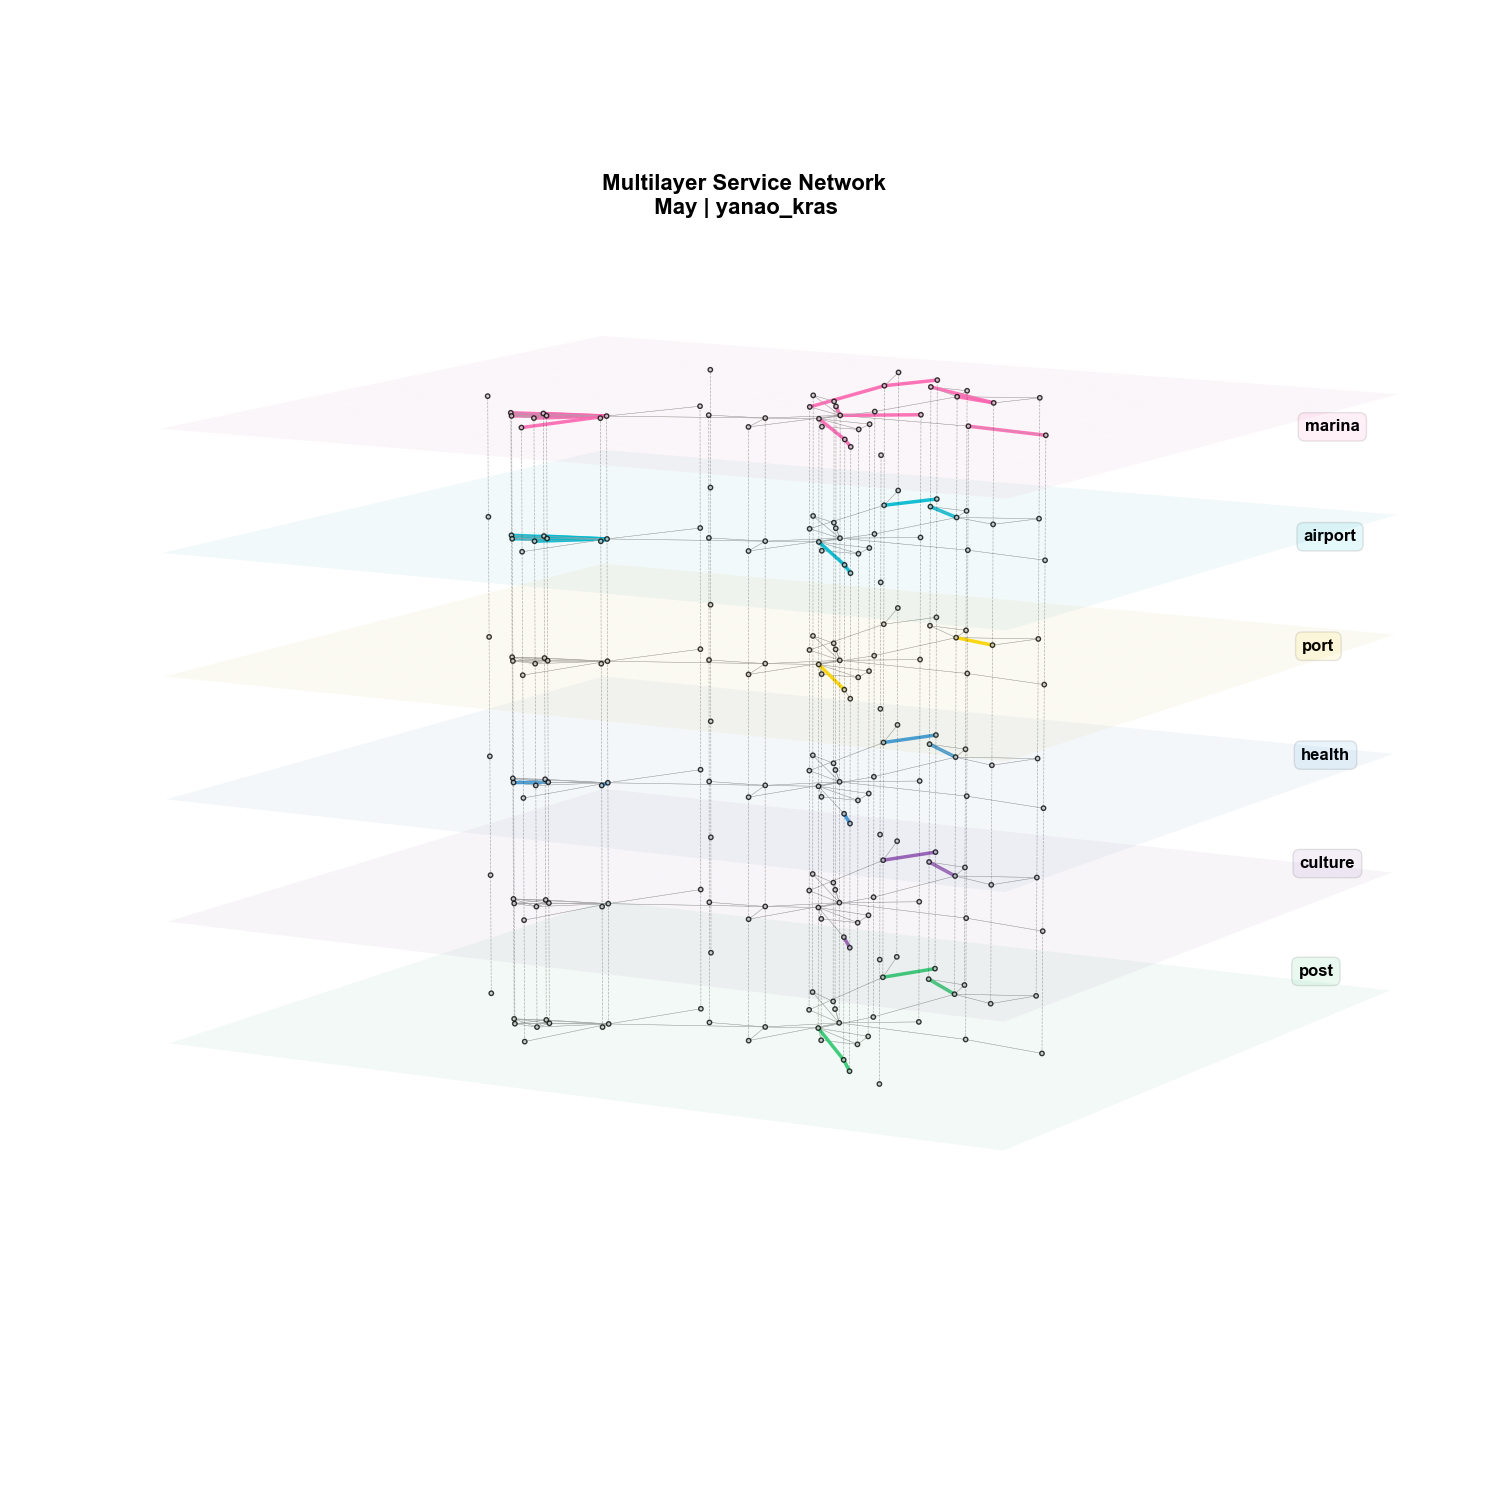

In [8]:
month = 4

# Example usage:
fig = plot_multilayer_network(
    all_results, "yanao_kras", service_list, month=month, figsize=(15, 30)
)


# time.sleep(2)  # Pause to ensure the plot is rendered before saving
# plt.savefig(
#     f"../plots/multilayer_network_{SETTL_NAME}_{month_order[month]}.png",
#     bbox_inches="tight",
#     dpi=300,
# )


## 4. Sankey chart

In [9]:
# for service in service_list:
for service in service_list:
    month_start = 4
    end_month = 10
    graphs = all_results["yanao_kras"][service]["stats"].graphs[month_start:end_month]
    _ = create_clean_sankey(graphs, service_name=service, month_start=month_start)


Creating Sankey for 6 time periods...
Excluding 32 self-sufficient settlements: ['Novaja', 'Syndassko', 'Vorontsovo', 'Kresty', 'Hatanga', 'Volochanka', 'Bajkalovsk', 'Potapovo', 'Tarko-Sale', 'Nosok', "Ust'-Port", 'Dudinka', 'Tuhard', 'Nahodka', 'Zhdaniha', 'Antipajuta', "Tol'ka", 'Gyda', 'Tazovskij', 'Popigaj', 'Gaz-Sale', 'Heta', 'Hantajskoe Ozero', 'Novorybnaja', 'Katyryk', "Krasnosel'kup", 'Karaul', 'Ratta', "Noril'sk", "Ust'-Avam", 'Dikson', 'Novyj Urengoj']
Found 6 consumers
T1: 3 assignments, 3 no provider
T2: 6 assignments, 0 no provider
T3: 6 assignments, 0 no provider
T4: 6 assignments, 0 no provider
T5: 6 assignments, 0 no provider
T6: 3 assignments, 3 no provider
Created 34 nodes
Created 36 flows


Creating Sankey for 6 time periods...
Excluding 33 self-sufficient settlements: ['Novaja', 'Syndassko', 'Vorontsovo', 'Kresty', 'Hatanga', 'Volochanka', 'Levinskie Peski', 'Bajkalovsk', 'Potapovo', 'Tarko-Sale', 'Nosok', "Ust'-Port", 'Dudinka', 'Tuhard', 'Nahodka', 'Zhdaniha', 'Antipajuta', "Tol'ka", 'Gyda', 'Tazovskij', 'Popigaj', 'Gaz-Sale', 'Heta', 'Hantajskoe Ozero', 'Novorybnaja', 'Katyryk', "Krasnosel'kup", 'Karaul', 'Ratta', "Noril'sk", "Ust'-Avam", 'Dikson', 'Novyj Urengoj']
Found 5 consumers
T1: 3 assignments, 2 no provider
T2: 5 assignments, 0 no provider
T3: 5 assignments, 0 no provider
T4: 5 assignments, 0 no provider
T5: 5 assignments, 0 no provider
T6: 3 assignments, 2 no provider
Created 29 nodes
Created 30 flows


Creating Sankey for 6 time periods...
Excluding 30 self-sufficient settlements: ['Novaja', 'Vorontsovo', 'Kresty', 'Hatanga', 'Volochanka', 'Bajkalovsk', 'Potapovo', 'Tarko-Sale', 'Nosok', "Ust'-Port", 'Dudinka', 'Tuhard', 'Nahodka', 'Zhdaniha', 'Antipajuta', "Tol'ka", 'Gyda', 'Tazovskij', 'Popigaj', 'Gaz-Sale', 'Heta', 'Hantajskoe Ozero', 'Katyryk', "Krasnosel'kup", 'Karaul', 'Ratta', "Noril'sk", "Ust'-Avam", 'Dikson', 'Novyj Urengoj']
Found 8 consumers
T1: 5 assignments, 3 no provider
T2: 8 assignments, 0 no provider
T3: 8 assignments, 0 no provider
T4: 8 assignments, 0 no provider
T5: 8 assignments, 0 no provider
T6: 5 assignments, 3 no provider
Created 48 nodes
Created 48 flows


Creating Sankey for 6 time periods...
Excluding 37 self-sufficient settlements: ['Novaja', 'Syndassko', 'Vorontsovo', 'Kresty', 'Hatanga', 'Volochanka', 'Levinskie Peski', 'Bajkalovsk', 'Potapovo', 'Tarko-Sale', 'Nosok', "Ust'-Port", 'Dudinka', 'Kikkiakki', 'Tuhard', 'Nahodka', 'Zhdaniha', 'Antipajuta', 'Gyda', 'Tazovskij', 'Popigaj', 'Gaz-Sale', 'Heta', 'Hantajskoe Ozero', 'Munguj', 'Novorybnaja', 'Katyryk', "Krasnosel'kup", 'Karaul', 'Ratta', 'Tibej-Sale', "Noril'sk", 'Polikarpovsk', 'Kazantsevo', "Ust'-Avam", 'Dikson', 'Novyj Urengoj']
Found 1 consumers
T1: 1 assignments, 0 no provider
T2: 1 assignments, 0 no provider
T3: 1 assignments, 0 no provider
T4: 1 assignments, 0 no provider
T5: 1 assignments, 0 no provider
T6: 1 assignments, 0 no provider
Created 7 nodes
Created 6 flows


Creating Sankey for 6 time periods...
Excluding 26 self-sufficient settlements: ['Vorontsovo', 'Hatanga', 'Volochanka', 'Bajkalovsk', 'Potapovo', 'Tarko-Sale', 'Nosok', "Ust'-Port", 'Dudinka', 'Tuhard', 'Nahodka', 'Antipajuta', "Tol'ka", 'Gyda', 'Tazovskij', 'Popigaj', 'Gaz-Sale', 'Hantajskoe Ozero', 'Katyryk', "Krasnosel'kup", 'Karaul', 'Ratta', "Noril'sk", "Ust'-Avam", 'Dikson', 'Novyj Urengoj']
Found 12 consumers
T1: 9 assignments, 3 no provider
T2: 12 assignments, 0 no provider
T3: 12 assignments, 0 no provider
T4: 12 assignments, 0 no provider
T5: 12 assignments, 0 no provider
T6: 9 assignments, 3 no provider
Created 46 nodes
Created 72 flows


Creating Sankey for 6 time periods...
Excluding 21 self-sufficient settlements: ['Vorontsovo', 'Hatanga', 'Potapovo', 'Tarko-Sale', 'Nosok', 'Dudinka', 'Tuhard', 'Nahodka', 'Antipajuta', 'Gyda', 'Tazovskij', 'Popigaj', 'Gaz-Sale', 'Hantajskoe Ozero', 'Munguj', "Krasnosel'kup", 'Karaul', 'Ratta', "Noril'sk", 'Dikson', 'Novyj Urengoj']
Found 17 consumers
T1: 14 assignments, 3 no provider
T2: 17 assignments, 0 no provider
T3: 17 assignments, 0 no provider
T4: 17 assignments, 0 no provider
T5: 17 assignments, 0 no provider
T6: 14 assignments, 3 no provider
Created 55 nodes
Created 102 flows


## 5. Circular flow chart

In [10]:
month_n = 5
# for service in service_list:
for service in ["marina"]:
    # graphs = all_results[SETTL_NAME][service]["stats"].graphs[month_start:end_month]
    graphs = all_results["yanao_kras"][service]["stats"].graphs[month_n : month_n + 1]
    for i, g in enumerate(graphs):
        fig = plot_circular_network_sankey_style(
            g,
            service_name=service,
            month_name=month_order[month_start + i],
        )
        fig.show()


## 6. Service coverage map

In [11]:
settl_name_lst


['yakut_chuk', 'yanao_kras', 'mezen', 'nao']

In [ ]:
from collections import defaultdict
from scripts.preprocesser.constants import SERVICE_COLORS, service_list, month_order
from scipy.spatial import ConvexHull
import numpy as np


def build_temporal_service_evolution_geojson_by_month(
    all_results, settl_name, month_range
):
    """
    Returns: {month_idx: FeatureCollection}
    - Each FeatureCollection has service_area polygons + provider points for that month.
    - Base network nodes are added to every month’s FeatureCollection for convenience.
    """
    months = list(month_range)

    # Collect consistent node positions once
    all_positions = {}
    for month_idx in months:
        for service in service_list:
            try:
                graph = all_results[settl_name][service]["stats"].graphs[month_idx]
                for node, data in graph.nodes(data=True):
                    if node not in all_positions:
                        if "x" in data and "y" in data:
                            all_positions[node] = (data["x"], data["y"])
                        elif "longitude" in data and "latitude" in data:
                            all_positions[node] = (data["longitude"], data["latitude"])
                if all_positions:
                    break
            except Exception:
                continue
        if all_positions:
            break

    by_month = {}

    for month_idx in months:
        fc = {"type": "FeatureCollection", "features": []}

        # Base nodes
        for node_id, (x, y) in all_positions.items():
            fc["features"].append(
                {
                    "type": "Feature",
                    "geometry": {"type": "Point", "coordinates": [float(x), float(y)]},
                    "properties": {
                        "feature_type": "node",
                        "settlement": settl_name,
                        "node_id": node_id,
                        "month_index": int(month_idx),
                        "month_name": (
                            month_order[month_idx]
                            if month_idx < len(month_order)
                            else f"Month {month_idx}"
                        ),
                    },
                }
            )

        # Service areas + providers
        for service in service_list:
            try:
                graph = all_results[settl_name][service]["stats"].graphs[month_idx]

                providers = defaultdict(set)
                for source, target, data in graph.edges(data=True):
                    if (
                        data.get("is_service_flow", False)
                        and data.get("assignment", 0) > 0
                        and source != target
                    ):
                        providers[target].add(source)

                for provider, consumers in providers.items():
                    if len(consumers) < 1:
                        continue

                    group_nodes = consumers | {provider}
                    group_pos = [
                        all_positions[node]
                        for node in group_nodes
                        if node in all_positions
                    ]

                    # Polygon
                    if len(group_pos) >= 3:
                        try:
                            points = np.array(group_pos)
                            hull = ConvexHull(points)
                            hull_points = points[hull.vertices]
                            ring = [[float(x), float(y)] for x, y in hull_points]
                            if ring and ring[0] != ring[-1]:
                                ring.append(ring[0])
                            fc["features"].append(
                                {
                                    "type": "Feature",
                                    "geometry": {
                                        "type": "Polygon",
                                        "coordinates": [ring],
                                    },
                                    "properties": {
                                        "feature_type": "service_area",
                                        "settlement": settl_name,
                                        "month_index": int(month_idx),
                                        "month_name": (
                                            month_order[month_idx]
                                            if month_idx < len(month_order)
                                            else f"Month {month_idx}"
                                        ),
                                        "service": service,
                                        "provider": provider,
                                        "num_consumers": int(len(consumers)),
                                    },
                                }
                            )
                        except Exception:
                            pass

                    # Provider point
                    if provider in all_positions:
                        px, py = all_positions[provider]
                        fc["features"].append(
                            {
                                "type": "Feature",
                                "geometry": {
                                    "type": "Point",
                                    "coordinates": [float(px), float(py)],
                                },
                                "properties": {
                                    "feature_type": "provider",
                                    "settlement": settl_name,
                                    "month_index": int(month_idx),
                                    "month_name": (
                                        month_order[month_idx]
                                        if month_idx < len(month_order)
                                        else f"Month {month_idx}"
                                    ),
                                    "service": service,
                                    "provider": provider,
                                    "num_consumers": int(len(consumers)),
                                },
                            }
                        )

            except Exception:
                continue

        by_month[month_idx] = fc

    return by_month


# usage:
# geo_by_month = build_temporal_service_evolution_geojson_by_month(all_results, "yanao_kras", range(4, 10))
# geo_by_month[4]  # May FeatureCollection

geo = build_temporal_service_evolution_geojson_by_month(
    all_results,
    "yakut_chuk",
    month_range=range(4, 10),
)
# `geo` is a GeoJSON FeatureCollection dict


In [ ]:
settl_name_lst


['yakut_chuk', 'yanao_kras', 'mezen', 'nao']

In [ ]:
import geopandas as gpd

# Set CRS if your coords are lon/lat; adjust if projected
gdf = gpd.GeoDataFrame.from_features(geo[4]["features"], crs="EPSG:3857")
gdf.explore()


In [ ]:
str(list(geo.keys()))


'[4, 5, 6, 7, 8, 9]'

In [ ]:
# Set CRS if your coords are lon/lat; adjust if projected
gdf = gpd.GeoDataFrame.from_features(geo[7]["features"], crs="EPSG:3857")
gdf.explore()


In [30]:
import geopandas as gpd
from shapely.geometry import LineString, Point


def build_edge_lines_by_month(all_results, settl_name, month_range, crs="EPSG:4326"):
    months = list(month_range)
    edges_by_month = {}
    nodes_by_month = {}

    # Collect positions once (x/y or lon/lat)
    all_positions = {}
    for month_idx in months:
        for service in service_list:
            try:
                g = all_results[settl_name][service]["stats"].graphs[month_idx]
                for n, d in g.nodes(data=True):
                    if n not in all_positions:
                        if "x" in d and "y" in d:
                            all_positions[n] = (d["x"], d["y"])
                        elif "longitude" in d and "latitude" in d:
                            all_positions[n] = (d["longitude"], d["latitude"])
                if all_positions:
                    break
            except Exception:
                continue
        if all_positions:
            break

    for month_idx in months:
        edge_rows = []
        node_rows = {}

        for service in service_list:
            try:
                g = all_results[settl_name][service]["stats"].graphs[month_idx]

                # nodes
                for n, d in g.nodes(data=True):
                    # print(n, d)
                    if n in all_positions and n not in node_rows:
                        x, y = all_positions[n]
                        node_rows[n] = {
                            **d,
                            "geometry": Point(x, y),
                            "node_id": n,
                        }

                # edges
                for u, v, data in g.edges(data=True):
                    if (
                        data.get("is_service_flow", False)
                        and data.get("assignment", 0) > 0
                    ):
                        if u in all_positions and v in all_positions:
                            a, b = all_positions[u], all_positions[v]
                            edge_rows.append(
                                {
                                    "geometry": LineString([a, b]),
                                    "service": service,
                                    "label": data.get("label", 0),
                                    "assignment": data.get("assignment", 0),
                                    "month_index": int(month_idx),
                                    "month_name": (
                                        month_order[month_idx]
                                        if month_idx < len(month_order)
                                        else f"Month {month_idx}"
                                    ),
                                }
                            )
            except Exception:
                continue

        edges_by_month[month_idx] = gpd.GeoDataFrame(edge_rows, crs=crs)
        nodes_by_month[month_idx] = gpd.GeoDataFrame(list(node_rows.values()), crs=crs)

    return edges_by_month, nodes_by_month


for s in settl_name_lst:
    edges_by_month, nodes_by_month = build_edge_lines_by_month(
        all_results, s, range(4, 10), crs="EPSG:3857"
    )

    for mnth in [4, 8]:
        edges_by_month[mnth].to_crs(4326).to_file(
            f"edges_{s}_month_n_{mnth}_service_{service}.geojson"
        )  # May edges
        nodes_by_month[mnth].to_crs(4326).to_file(
            f"nodes_{s}_month_n_{mnth}_service_{service}.geojson"
        )  # May edges


In [ ]:
nodes_by_month[mnth]


,geometry,node_id
0,POINT (5924488.233 10414754.194),Andeg
1,POINT (5928867.564 10379371.634),Kuja
2,POINT (5895205.385 10440998.709),Nel'min-Nos
3,POINT (4512863.428 9489111.662),Arhangel'sk
4,POINT (5457924.836 10345490.522),Indiga
5,POINT (4925227.51 9836167.312),Mezen'
6,POINT (5899613.533 10340564.551),Nar'jan-Mar
7,POINT (4973614.564 10043269.742),Nes'
8,POINT (5316638.985 10085906.407),Nizhnjaja Pesha
9,POINT (5175777.65 10055151.521),Oma


In [ ]:
edges_by_month[4].explore()


In [ ]:
import folium

m = None
cmap = "Set2"

month_idx = 4

gdf = edges_by_month[month_idx]
if m is None:
    m = folium.Map(location=[0, 0], zoom_start=4)  # will recenter via explore

if not gdf.empty:
    m = gdf.explore(
        m=m,
        column="label",
        cmap=cmap,
        categorical=True,
        legend=(m is None),  # one legend
        style_kwds={"weight": 2.0, "opacity": 0.8},
        name=f"Month {month_idx} lines",
    )

folium.LayerControl(collapsed=False).add_to(m)
m


In [ ]:
gdf = edges_by_month[month_idx]
gdf


,geometry,service,label,assignment,month_index,month_name
0,"LINESTRING (17193167.67 10804423.881, 17193167...",post,0,89,4,May
1,"LINESTRING (17073844.986 10580021.583, 1707384...",post,0,57,4,May
2,"LINESTRING (18528580.97 10463420.383, 18697501...",post,Winter road,577,4,May
3,"LINESTRING (18528580.97 10463420.383, 17959177...",post,Winter road,77,4,May
4,"LINESTRING (17221959.009 10529031.637, 1722195...",post,0,64,4,May
...,...,...,...,...,...,...
112,"LINESTRING (17959177.98 10674235.907, 17959177...",marina,0,317,4,May
113,"LINESTRING (16781079.089 10565154.505, 1795917...",marina,Winter road,55,4,May
114,"LINESTRING (18494942.927 10400079.987, 1678721...",marina,Aviation,41,4,May
115,"LINESTRING (16787211.005 8303937.249, 16787211...",marina,0,10851,4,May


In [ ]:
gdf


In [ ]:
points_gdf = gdf[gdf.geometry.geom_type == "Point"].copy()


In [ ]:
points_gdf = gdf[gdf.geometry.geom_type == "Point"].copy()
points_gdf


,geometry,service,label,assignment,month_index,month_name


In [ ]:
list(all_results["yanao_kras"]["marina"]["net"].graph.edges(data=True))


[('Antipajuta', 'Gyda', {'weight': 80.0, 'label': 'Aviation'}),
 ('Antipajuta', 'Gyda', {'weight': 80.0, 'label': 'Aviation'}),
 ('Antipajuta', 'Nahodka', {'weight': 45.0, 'label': 'Aviation'}),
 ('Antipajuta', 'Nahodka', {'weight': 45.0, 'label': 'Aviation'}),
 ('Antipajuta', 'Tazovskij', {'weight': 90.0, 'label': 'Aviation'}),
 ('Antipajuta', 'Tazovskij', {'weight': 90.0, 'label': 'Aviation'}),
 ('Gyda', 'Tazovskij', {'weight': 170.0, 'label': 'Aviation'}),
 ('Gyda', 'Tazovskij', {'weight': 170.0, 'label': 'Aviation'}),
 ('Nahodka', 'Tazovskij', {'weight': 170.0, 'label': 'Aviation'}),
 ('Nahodka', 'Tazovskij', {'weight': 170.0, 'label': 'Aviation'}),
 ('Bajkalovsk', 'Vorontsovo', {'weight': 34.0, 'label': 'Aviation'}),
 ('Bajkalovsk', 'Vorontsovo', {'weight': 34.0, 'label': 'Aviation'}),
 ('Bajkalovsk', 'Dudinka', {'weight': 52.0, 'label': 'Aviation'}),
 ('Bajkalovsk', 'Dudinka', {'weight': 52.0, 'label': 'Aviation'}),
 ('Bajkalovsk', 'Karaul', {'weight': 186.0, 'label': 'Water tran

In [ ]:
# Set CRS if your coords are lon/lat; adjust if projected
gdf = gpd.GeoDataFrame.from_features(geo[7]["features"], crs="EPSG:3857")

polys = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])]
pts = gdf[gdf.geometry.type == "Point"]

m = polys.explore(
    column="service",
    cmap="Set2",
    categorical=True,
    legend=True,
    style_kwds={"fillOpacity": 0.35, "weight": 1},
)
pts.explore(
    m=m,
    column="service",
    cmap="Set2",
    categorical=True,
    marker_type="circle",
    marker_kwds={"radius": 600, "fillOpacity": 0.9, "weight": 100, "color": "black"},
)
m


In [ ]:
# Set CRS if your coords are lon/lat; adjust if projected
gdf = gpd.GeoDataFrame.from_features(geo[4]["features"], crs="EPSG:3857")

polys = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])]
pts = gdf[gdf.geometry.type == "Point"]

m = polys.explore(
    column="service",
    cmap="Set2",
    categorical=True,
    legend=True,
    style_kwds={"fillOpacity": 0.35, "weight": 1},
)
pts.explore(
    m=m,
    column="service",
    cmap="Set2",
    categorical=True,
    marker_type="circle",
    marker_kwds={"radius": 6, "fillOpacity": 0.9, "weight": 1, "color": "black"},
)
m


yanao_kras


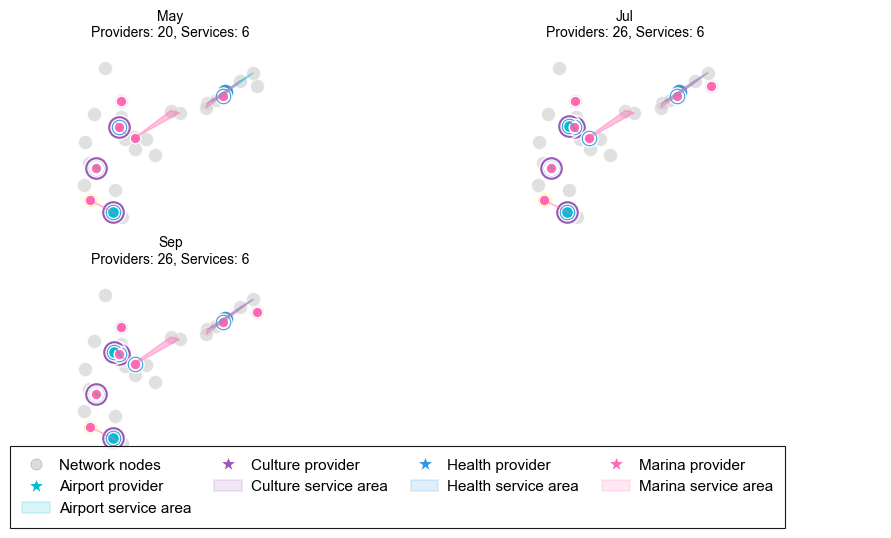

In [ ]:
# SETTL_NAME = "yakut_chuk"

for settl in ["yanao_kras"]:
    print(settl)

    MONTH_RANGE = range(4, 10, 2)  # May to October (indices 4-9)

    ax = plot_temporal_service_evolution(all_results, settl, MONTH_RANGE)

    # MONTH_RANGE = range(12)  # May to October (indices 4-9)
    # metrics, communities = calculate_temporal_metrics(
    #     all_results,
    #     settl,
    #     MONTH_RANGE,
    #     service_list=service_list,
    #     month_order=month_order,
    # )
    # _ = plot_temporal_metrics(metrics)


In [ ]:
communities


{0: {'post': {'Gaz-Sale': frozenset({'Gaz-Sale', 'Tazovskij', 'Tibej-Sale'}),
   'Karaul': frozenset({'Karaul', 'Polikarpovsk'}),
   "Tol'ka": frozenset({'Kikkiakki', "Tol'ka"})},
  'culture': {'Gaz-Sale': frozenset({'Gaz-Sale', 'Tibej-Sale'}),
   'Karaul': frozenset({'Karaul', 'Polikarpovsk'}),
   "Tol'ka": frozenset({'Kikkiakki', "Tol'ka"})},
  'health': {'Gaz-Sale': frozenset({'Gaz-Sale', 'Tibej-Sale'}),
   'Karaul': frozenset({'Karaul', 'Polikarpovsk'}),
   'Zhdaniha': frozenset({'Novorybnaja', 'Zhdaniha'}),
   "Tol'ka": frozenset({'Kikkiakki', "Tol'ka"}),
   'Hatanga': frozenset({'Hatanga', 'Syndassko'})},
  'port': {'Gaz-Sale': frozenset({'Gaz-Sale', 'Tazovskij'}),
   'Tarko-Sale': frozenset({'Tarko-Sale', "Tol'ka"})},
  'airport': {'Gaz-Sale': frozenset({'Gaz-Sale', 'Tazovskij', 'Tibej-Sale'}),
   'Hatanga': frozenset({'Hatanga',
              'Heta',
              'Kresty',
              'Novaja',
              'Novorybnaja',
              'Syndassko',
              'Zhdaniha'}

In [ ]:
from collections import defaultdict
import pandas as pd


def provider_catchments(data, t, service):
    # provider -> set(consumers)
    return {p: set(cs) for p, cs in data[t].get(service, {}).items()}


def consumer_provider_sets(catchments):
    # consumer -> set(providers)
    c2ps = defaultdict(set)
    for p, Cs in catchments.items():
        for c in Cs:
            c2ps[c].add(p)
    return c2ps


def jaccard(A, B):
    A = set(A)
    B = set(B)
    if not A and not B:
        return 1.0
    return len(A & B) / len(A | B)


def month_to_month_metrics_multimember(data, service="marina"):
    months = sorted(data.keys())

    # Universe of consumers across the year (service-specific)
    U = set()
    for t in months:
        for p, Cs in data[t].get(service, {}).items():
            U |= set(Cs)
    N = len(U)

    system_rows = []
    provider_rows = []
    consumer_rows = []

    for t0, t1 in zip(months[:-1], months[1:]):
        catch0 = provider_catchments(data, t0, service)
        catch1 = provider_catchments(data, t1, service)

        # --- Provider-side metrics ---
        provs = sorted(set(catch0.keys()) | set(catch1.keys()))
        sizes0 = {p: len(catch0.get(p, set())) for p in provs}
        denom_sizes0 = sum(sizes0.values()) or 1

        provider_j = {}
        for p in provs:
            C0 = catch0.get(p, set())
            C1 = catch1.get(p, set())
            inter = C0 & C1
            union = C0 | C1

            Jp = jaccard(C0, C1)
            provider_j[p] = Jp

            size0, size1 = len(C0), len(C1)
            loss_share = 1.0 - (len(inter) / size0) if size0 else 0.0
            gain_share = 1.0 - (len(inter) / size1) if size1 else 0.0

            provider_rows.append(
                {
                    "t_from": t0,
                    "t_to": t1,
                    "provider": p,
                    "size_from": size0,
                    "size_to": size1,
                    "jaccard": Jp,
                    "loss_share": loss_share,
                    "gain_share": gain_share,
                    "net_change": size1 - size0,
                }
            )

        # Weighted mean provider Jaccard (weights by catchment size at t0)
        wmean_provider_j = sum(
            (sizes0[p] / denom_sizes0) * provider_j[p] for p in provs
        )

        # --- Consumer-side provider-option stability ---
        c2ps0 = consumer_provider_sets(catch0)
        c2ps1 = consumer_provider_sets(catch1)

        Ji_vals = []
        iso0 = iso1 = newly_iso = newly_conn = 0

        for c in U:
            P0 = c2ps0.get(c, set())
            P1 = c2ps1.get(c, set())

            Ji = jaccard(P0, P1)
            Ji_vals.append(Ji)

            is0 = len(P0) == 0
            is1 = len(P1) == 0
            iso0 += is0
            iso1 += is1
            newly_iso += not is0 and is1
            newly_conn += is0 and not is1

            consumer_rows.append(
                {
                    "t_from": t0,
                    "t_to": t1,
                    "consumer": c,
                    "n_providers_from": len(P0),
                    "n_providers_to": len(P1),
                    "providers_jaccard": Ji,
                }
            )

        mean_consumer_j = sum(Ji_vals) / len(Ji_vals) if Ji_vals else 1.0

        system_rows.append(
            {
                "t_from": t0,
                "t_to": t1,
                "N_consumers": N,
                "weighted_mean_provider_jaccard": wmean_provider_j,
                "mean_consumer_provider_set_jaccard": mean_consumer_j,
                "isolation_share_from": iso0 / N if N else 0.0,
                "isolation_share_to": iso1 / N if N else 0.0,
                "newly_isolated_share": newly_iso / N if N else 0.0,
                "newly_connected_share": newly_conn / N if N else 0.0,
            }
        )

    return (
        pd.DataFrame(system_rows),
        pd.DataFrame(provider_rows),
        pd.DataFrame(consumer_rows),
    )


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def _month_pair_labels(months, month_names=None):
    if month_names is None:
        month_names = [
            "Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "Sep",
            "Oct",
            "Nov",
            "Dec",
        ]
    # months are integer indices 0..11
    return [
        f"{month_names[a]}→{month_names[b]}" for a, b in zip(months[:-1], months[1:])
    ]


import numpy as np
import matplotlib.pyplot as plt


def plot_catchment_dynamics_styled(
    system_df, title_prefix="", month_names=None, savepath=None, figsize=(18, 5)
):
    """
    Styled to match plot_temporal_metrics() aesthetics.

    system_df columns expected:
      - t_from, t_to
      - weighted_mean_provider_jaccard
      - mean_consumer_provider_set_jaccard
      - isolation_share_from, isolation_share_to
      - newly_isolated_share, newly_connected_share
    """
    # --- palette consistent with your reference ---
    colors = {
        "primary": "#0077BE",  # blue
        "secondary": "#8E44AD",  # purple
        "accent": "#E67E22",  # orange
        "success": "#2ECC71",  # green
        "danger": "#E74C3C",  # red
        "neutral": "#34495E",  # dark gray
        "bg": "#F8F9FA",  # panel background
        "border": "#E0E0E0",
    }

    # Global rcParams (same spirit as your reference)
    plt.rcParams.update(
        {
            "font.family": "sans-serif",
            "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
            "font.size": 11,
            "axes.linewidth": 1.5,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.grid": True,
            "grid.alpha": 0.25,
            "grid.linewidth": 1.0,
            "grid.linestyle": "--",
            "xtick.direction": "out",
            "ytick.direction": "out",
            "xtick.major.size": 6,
            "ytick.major.size": 6,
            "xtick.color": colors["neutral"],
            "ytick.color": colors["neutral"],
        }
    )

    # Ensure ordered by time
    system_df = system_df.sort_values(["t_from", "t_to"]).reset_index(drop=True)

    # Build x labels
    months = list(system_df["t_from"].values) + [int(system_df["t_to"].values[-1])]
    xlabels = _month_pair_labels(months, month_names=month_names)
    x = np.arange(len(xlabels))

    # Series
    provJ = system_df["weighted_mean_provider_jaccard"].to_numpy()
    consJ = system_df["mean_consumer_provider_set_jaccard"].to_numpy()

    iso_to = system_df["isolation_share_to"].to_numpy()
    newly_iso = system_df["newly_isolated_share"].to_numpy()
    newly_conn = system_df["newly_connected_share"].to_numpy()

    # --- Figure & grid (like your reference: add_gridspec for spacing control) ---
    fig = plt.figure(figsize=figsize, facecolor="white")
    gs = fig.add_gridspec(
        1, 3, hspace=0.4, wspace=0.35, left=0.06, right=0.96, top=0.88, bottom=0.15
    )

    if title_prefix:
        fig.suptitle(
            title_prefix.strip(),
            y=0.98,
            fontsize=15,
            fontweight="bold",
            color=colors["neutral"],
        )

    # Helper: consistent axis styling
    def style_axis(ax):
        ax.set_facecolor(colors["bg"])
        ax.grid(True, alpha=0.25, linestyle="--", linewidth=1.0)
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)
            spine.set_color(colors["border"])
        ax.tick_params(axis="both", labelsize=11)

    # 1) Provider-side stability (thick line + hollow markers + subtle shadow)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(
        x,
        provJ,
        "o-",
        color=colors["primary"],
        linewidth=3.5,
        markersize=9,
        markerfacecolor="white",
        markeredgewidth=2.5,
        markeredgecolor=colors["primary"],
        alpha=0.9,
    )
    ax1.plot(
        x,
        provJ,
        "o-",
        color=colors["primary"],
        linewidth=1.5,
        markersize=9,
        alpha=0.3,
        zorder=0,
    )

    ax1.set_title(
        "Provider Catchment Stability\n(Weighted Jaccard)",
        fontsize=14,
        fontweight="bold",
        pad=18,
        color=colors["neutral"],
    )
    ax1.set_ylabel(
        "Jaccard Similarity", fontsize=13, fontweight="bold", color=colors["neutral"]
    )
    ax1.set_ylim(0, 1.05)
    ax1.set_xticks(x)
    ax1.set_xticklabels(
        xlabels,
        rotation=45,
        ha="right",
        fontsize=11,
        color=colors["neutral"],
        fontweight="medium",
    )
    style_axis(ax1)

    # 2) Consumer-side stability (square markers)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(
        x,
        consJ,
        "s-",
        color=colors["secondary"],
        linewidth=3.5,
        markersize=8,
        markerfacecolor="white",
        markeredgewidth=2.5,
        markeredgecolor=colors["secondary"],
        alpha=0.9,
    )
    ax2.plot(
        x,
        consJ,
        "s-",
        color=colors["secondary"],
        linewidth=1.5,
        markersize=8,
        alpha=0.3,
        zorder=0,
    )

    ax2.set_title(
        "Consumer Option-Set Stability\n(Mean Jaccard)",
        fontsize=14,
        fontweight="bold",
        pad=18,
        color=colors["neutral"],
    )
    ax2.set_ylabel(
        "Jaccard Similarity", fontsize=13, fontweight="bold", color=colors["neutral"]
    )
    ax2.set_ylim(0, 1.05)
    ax2.set_xticks(x)
    ax2.set_xticklabels(
        xlabels,
        rotation=45,
        ha="right",
        fontsize=11,
        color=colors["neutral"],
        fontweight="medium",
    )
    style_axis(ax2)

    # 3) Isolation dynamics (stacked + separate bar; palette like reference)
    ax3 = fig.add_subplot(gs[0, 2])

    # baseline isolation share (to)
    ax3.bar(
        x,
        iso_to,
        alpha=0.9,
        width=0.8,
        color=colors["primary"],
        edgecolor="white",
        linewidth=1.2,
        label="Isolation share (to)",
    )
    # newly isolated stacked on top
    ax3.bar(
        x,
        newly_iso,
        bottom=iso_to,
        alpha=0.9,
        width=0.8,
        color=colors["accent"],
        edgecolor="white",
        linewidth=1.2,
        label="Newly isolated",
    )
    # newly connected as separate bar (not stacked)
    ax3.bar(
        x,
        newly_conn,
        alpha=0.9,
        width=0.8,
        color=colors["success"],
        edgecolor="white",
        linewidth=1.2,
        label="Newly connected",
    )

    ax3.set_title(
        "Isolation Dynamics",
        fontsize=14,
        fontweight="bold",
        pad=18,
        color=colors["neutral"],
    )
    ax3.set_ylabel(
        "Share of settlements", fontsize=13, fontweight="bold", color=colors["neutral"]
    )
    ymax = (iso_to + newly_iso).max() if len(iso_to) else 0.05
    ax3.set_ylim(0, min(1.0, max(0.05, ymax * 1.25)))
    ax3.set_xticks(x)
    ax3.set_xticklabels(
        xlabels,
        rotation=45,
        ha="right",
        fontsize=11,
        color=colors["neutral"],
        fontweight="medium",
    )
    ax3.grid(True, axis="y", alpha=0.25, linestyle="--", linewidth=1.0)
    ax3.set_facecolor(colors["bg"])
    for spine in ax3.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color(colors["border"])

    # legend placement similar to your reference (below panel / centered)
    ax3.legend(
        loc="center", fontsize=10, ncol=2, bbox_to_anchor=(0.5, -0.28), framealpha=0.9
    )

    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()
    return _


In [ ]:
system_df, provider_df, consumer_df = month_to_month_metrics_multimember(
    communities, service="marina"
)


In [ ]:
service_list


['post', 'culture', 'health', 'port', 'airport', 'marina']

post


/var/folders/jn/d6x3c7jd7594dtldxq22ysn80000gn/T/ipykernel_4857/2439410989.py:282: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



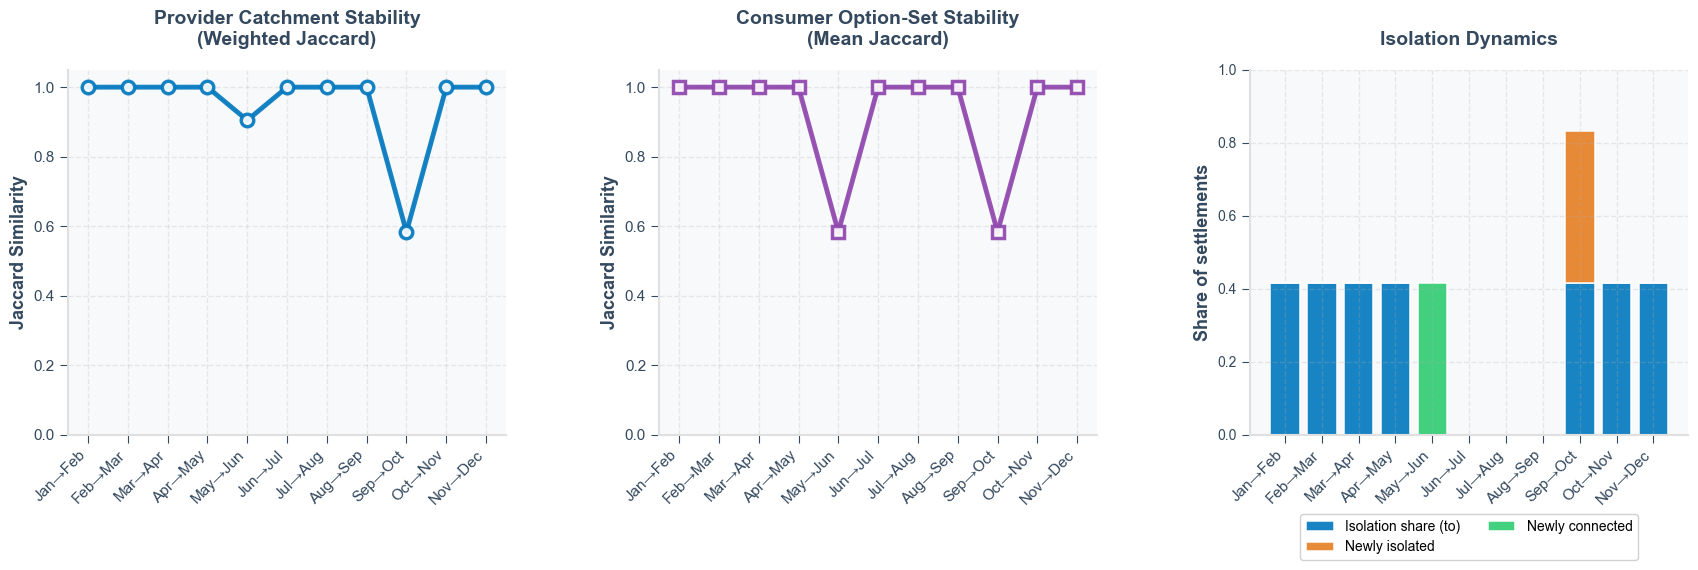

culture


/var/folders/jn/d6x3c7jd7594dtldxq22ysn80000gn/T/ipykernel_4857/2439410989.py:282: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



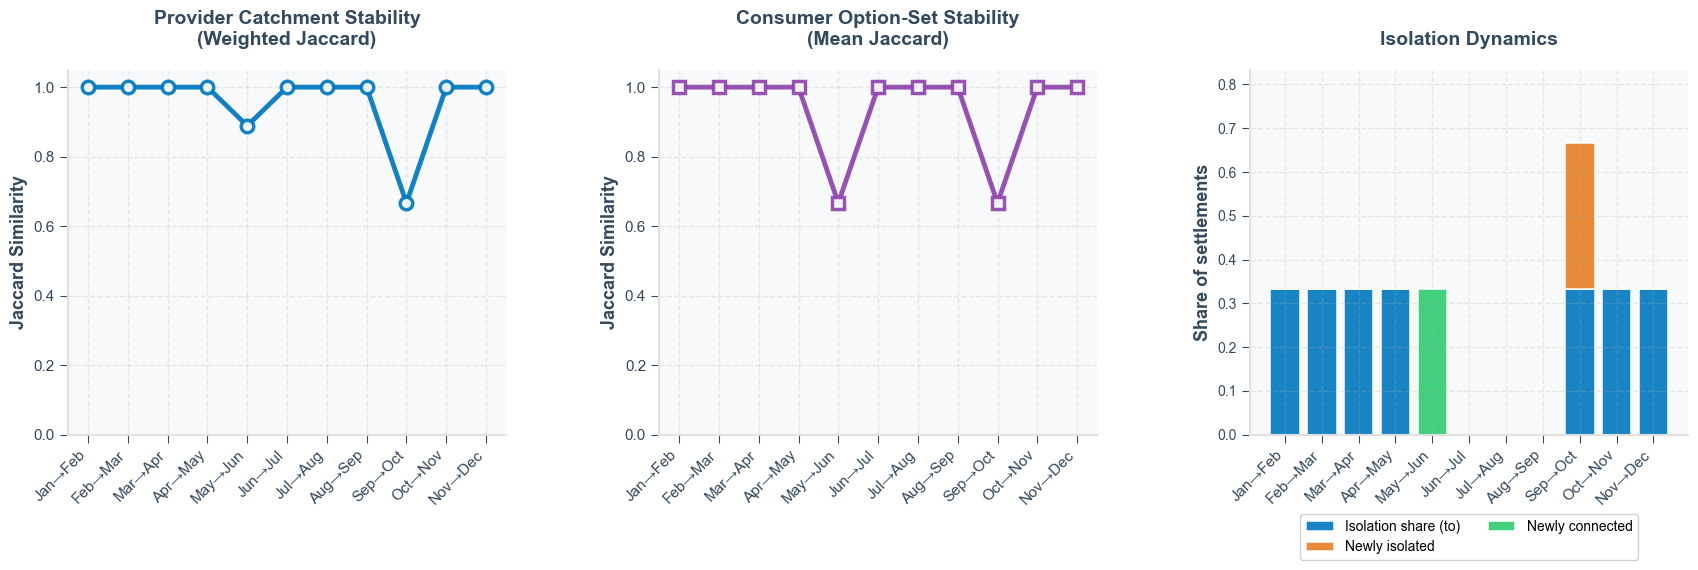

health


/var/folders/jn/d6x3c7jd7594dtldxq22ysn80000gn/T/ipykernel_4857/2439410989.py:282: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



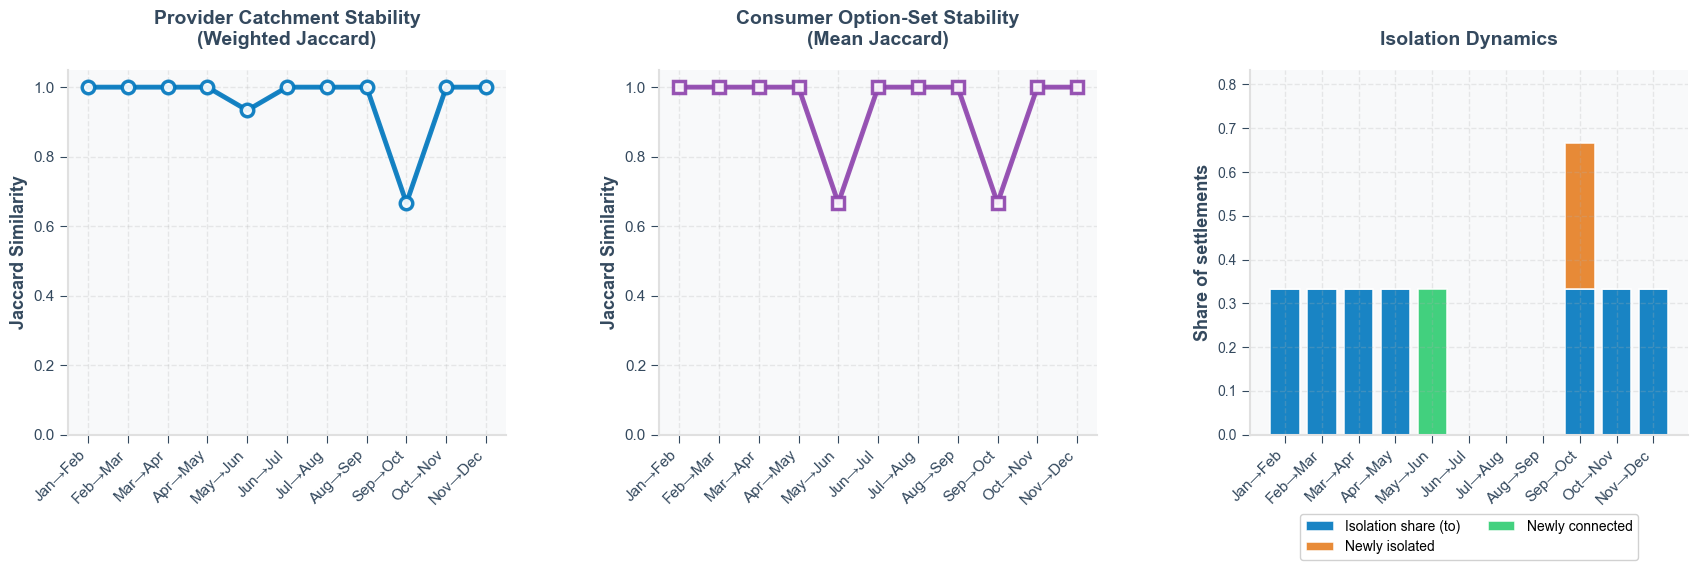

port


/var/folders/jn/d6x3c7jd7594dtldxq22ysn80000gn/T/ipykernel_4857/2439410989.py:282: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



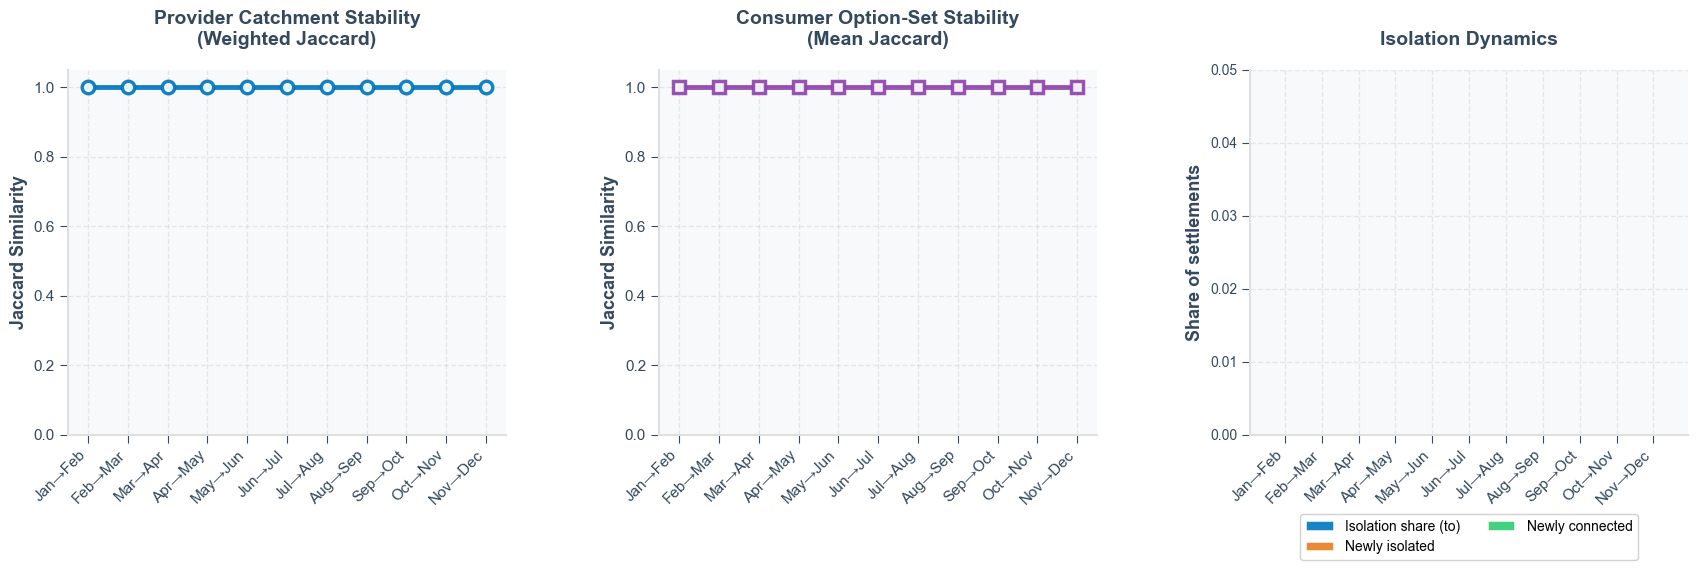

airport


/var/folders/jn/d6x3c7jd7594dtldxq22ysn80000gn/T/ipykernel_4857/2439410989.py:282: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



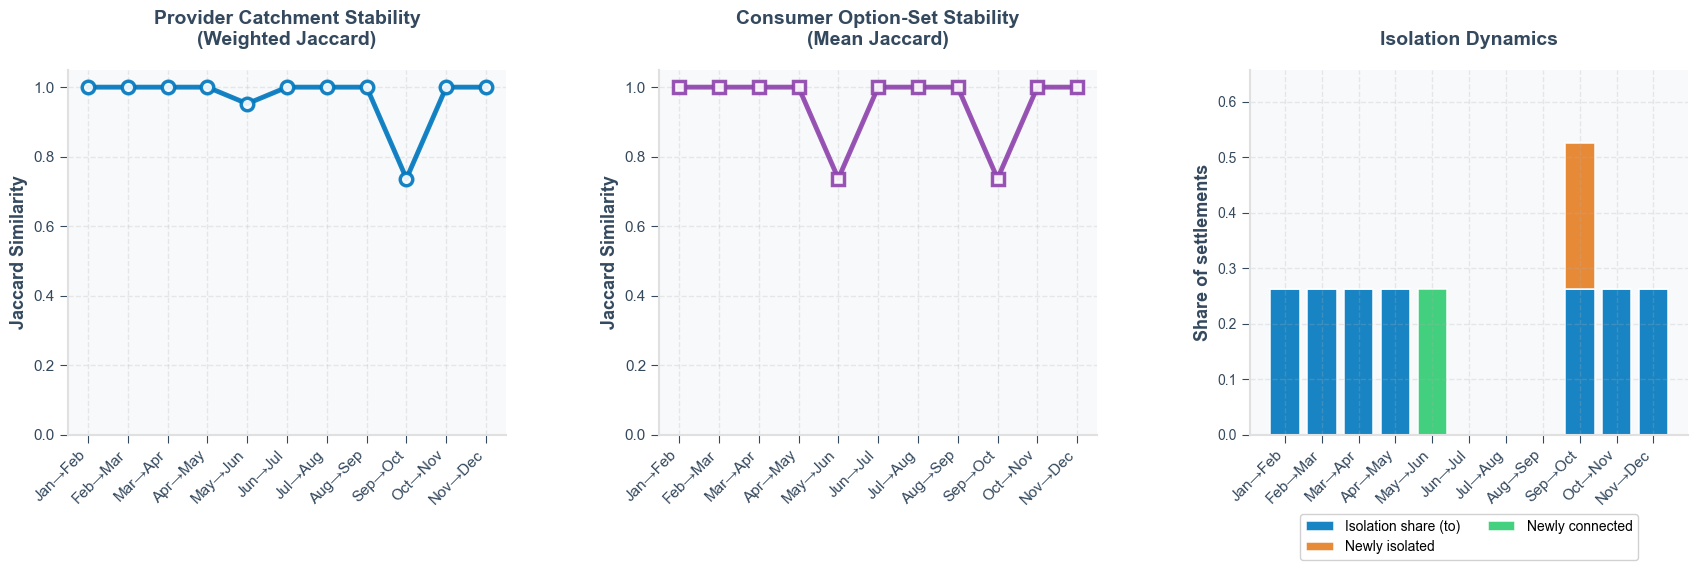

marina


/var/folders/jn/d6x3c7jd7594dtldxq22ysn80000gn/T/ipykernel_4857/2439410989.py:282: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



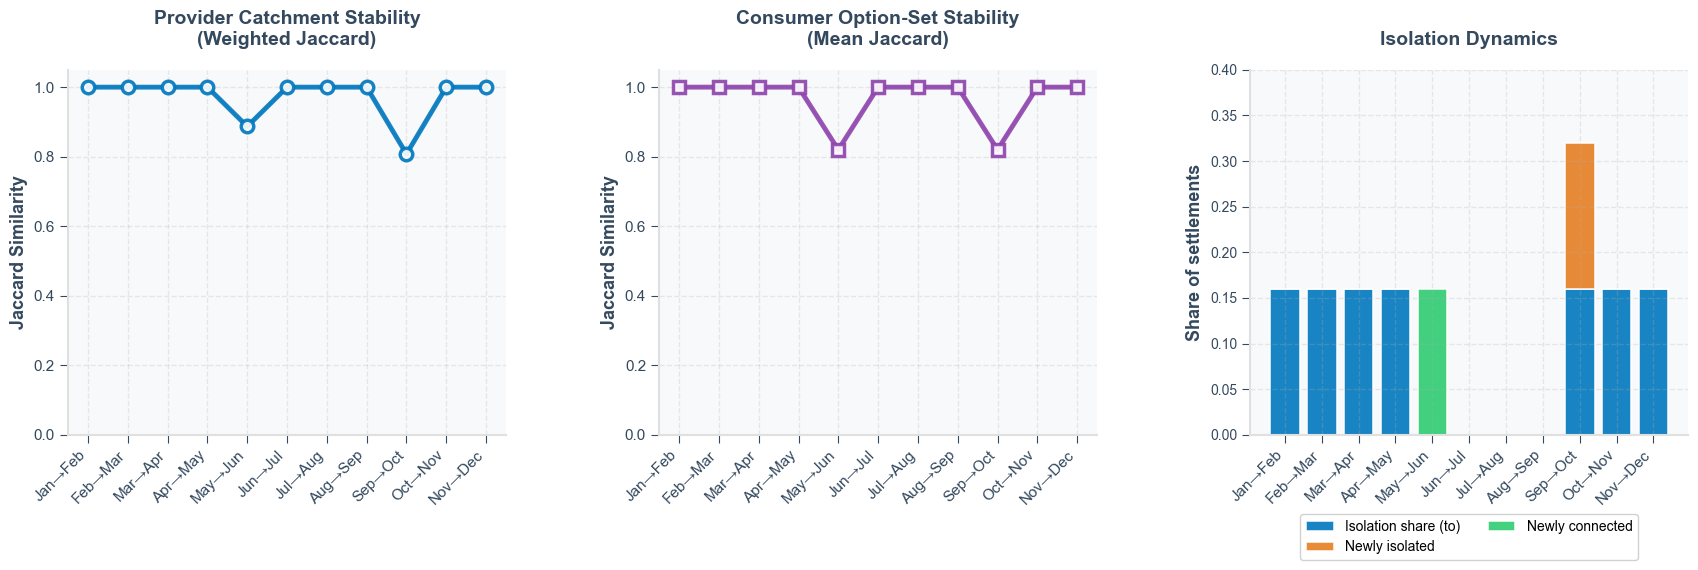

In [ ]:
for s in service_list:

    system_df, provider_df, consumer_df = month_to_month_metrics_multimember(
        communities, service=s
    )
    print(s)
    _ = plot_catchment_dynamics_styled(system_df, title_prefix="")


In [ ]:
system_df.columns


Index(['t_from', 't_to', 'N_consumers', 'weighted_mean_provider_jaccard',
       'mean_consumer_provider_set_jaccard', 'isolation_share_from',
       'isolation_share_to', 'newly_isolated_share', 'newly_connected_share'],
      dtype='object')

/var/folders/jn/d6x3c7jd7594dtldxq22ysn80000gn/T/ipykernel_4857/3359694754.py:150: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



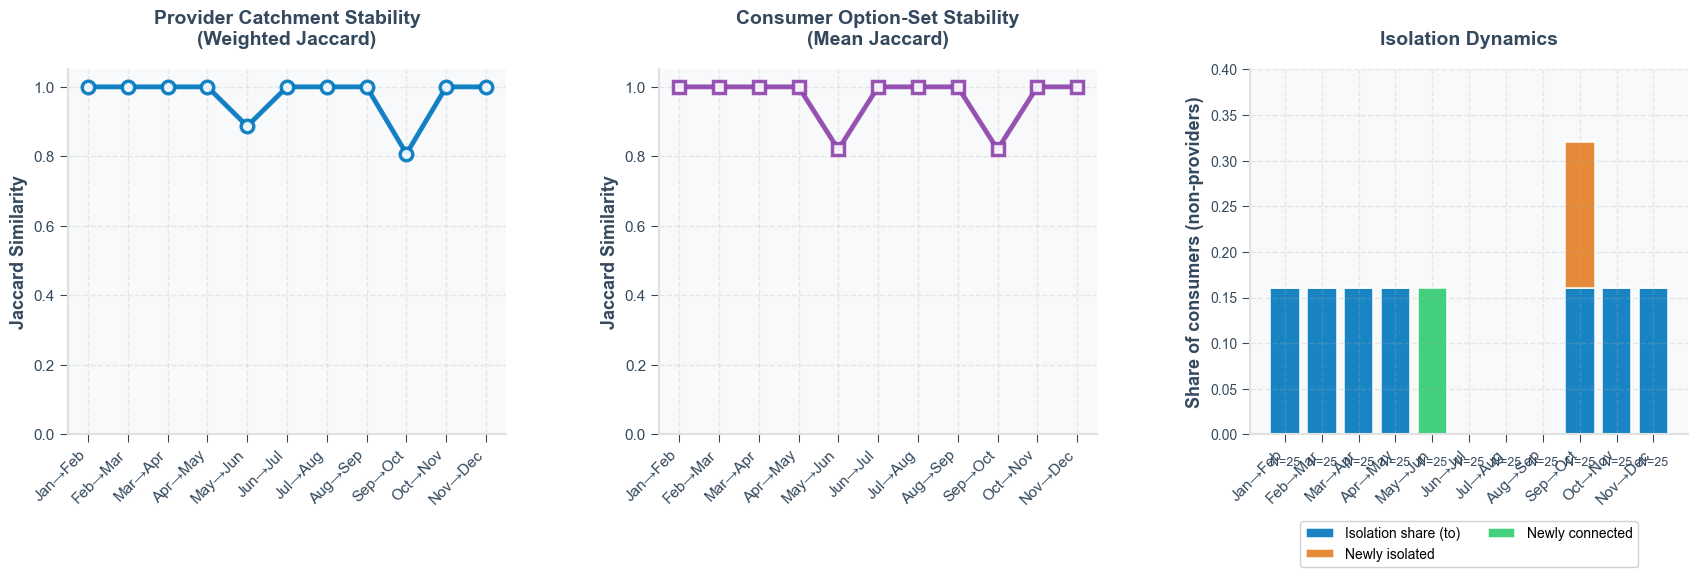

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_catchment_dynamics_styled(
    system_df,
    title_prefix="",
    month_names=None,
    savepath=None,
    figsize=(18, 5),
    use_nmi=False,  # set True once you add NMI column; for now it uses mean_consumer_provider_set_jaccard
    nmi_col="nmi_score",
):
    """
    Styled to match plot_temporal_metrics() aesthetics.

    Uses your *existing* system_df columns:
      - t_from, t_to
      - N_consumers
      - weighted_mean_provider_jaccard
      - mean_consumer_provider_set_jaccard  (or NMI if present)
      - isolation_share_from, isolation_share_to
      - newly_isolated_share, newly_connected_share

    SEMANTICS:
      - Isolation shares are interpreted as fractions of *consumers (non-providers)*.
      - Providers are assumed to have service access by definition and are excluded from isolation denominator.
    """

    colors = {
        "primary": "#0077BE",
        "secondary": "#8E44AD",
        "accent": "#E67E22",
        "success": "#2ECC71",
        "neutral": "#34495E",
        "bg": "#F8F9FA",
        "border": "#E0E0E0",
    }

    plt.rcParams.update(
        {
            "font.family": "sans-serif",
            "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
            "font.size": 11,
            "axes.linewidth": 1.5,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.grid": True,
            "grid.alpha": 0.25,
            "grid.linewidth": 1.0,
            "grid.linestyle": "--",
            "xtick.direction": "out",
            "ytick.direction": "out",
            "xtick.major.size": 6,
            "ytick.major.size": 6,
            "xtick.color": colors["neutral"],
            "ytick.color": colors["neutral"],
        }
    )

    system_df = system_df.sort_values(["t_from", "t_to"]).reset_index(drop=True)

    months = list(system_df["t_from"].values) + [int(system_df["t_to"].values[-1])]
    xlabels = _month_pair_labels(months, month_names=month_names)
    x = np.arange(len(xlabels))

    provJ = system_df["weighted_mean_provider_jaccard"].to_numpy()

    if use_nmi and (nmi_col in system_df.columns):
        sysSim = system_df[nmi_col].to_numpy()
        sys_ylabel = "NMI Score"
        sys_title = "System Similarity\n(NMI)"
    else:
        sysSim = system_df["mean_consumer_provider_set_jaccard"].to_numpy()
        sys_ylabel = "Jaccard Similarity"
        sys_title = "Consumer Option-Set Stability\n(Mean Jaccard)"

    N_cons = system_df["N_consumers"].to_numpy().astype(float)

    iso_to = system_df["isolation_share_to"].to_numpy()
    newly_iso = system_df["newly_isolated_share"].to_numpy()
    newly_conn = system_df["newly_connected_share"].to_numpy()

    # Optional: counts (helps interpretation; still plotted as shares)
    iso_to_n = iso_to * N_cons
    newly_iso_n = newly_iso * N_cons
    newly_conn_n = newly_conn * N_cons

    fig = plt.figure(figsize=figsize, facecolor="white")
    gs = fig.add_gridspec(
        1, 3, hspace=0.4, wspace=0.35, left=0.06, right=0.96, top=0.88, bottom=0.15
    )

    if title_prefix:
        fig.suptitle(
            title_prefix.strip(),
            y=0.98,
            fontsize=15,
            fontweight="bold",
            color=colors["neutral"],
        )

    def style_axis(ax):
        ax.set_facecolor(colors["bg"])
        ax.grid(True, alpha=0.25, linestyle="--", linewidth=1.0)
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)
            spine.set_color(colors["border"])
        ax.tick_params(axis="both", labelsize=11)

    # 1) Provider stability
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(
        x,
        provJ,
        "o-",
        color=colors["primary"],
        linewidth=3.5,
        markersize=9,
        markerfacecolor="white",
        markeredgewidth=2.5,
        markeredgecolor=colors["primary"],
        alpha=0.9,
    )
    ax1.plot(
        x,
        provJ,
        "o-",
        color=colors["primary"],
        linewidth=1.5,
        markersize=9,
        alpha=0.3,
        zorder=0,
    )
    ax1.set_title(
        "Provider Catchment Stability\n(Weighted Jaccard)",
        fontsize=14,
        fontweight="bold",
        pad=18,
        color=colors["neutral"],
    )
    ax1.set_ylabel(
        "Jaccard Similarity", fontsize=13, fontweight="bold", color=colors["neutral"]
    )
    ax1.set_ylim(0, 1.05)
    ax1.set_xticks(x)
    ax1.set_xticklabels(
        xlabels,
        rotation=45,
        ha="right",
        fontsize=11,
        color=colors["neutral"],
        fontweight="medium",
    )
    style_axis(ax1)

    # 2) System similarity
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(
        x,
        sysSim,
        "s-",
        color=colors["secondary"],
        linewidth=3.5,
        markersize=8,
        markerfacecolor="white",
        markeredgewidth=2.5,
        markeredgecolor=colors["secondary"],
        alpha=0.9,
    )
    ax2.plot(
        x,
        sysSim,
        "s-",
        color=colors["secondary"],
        linewidth=1.5,
        markersize=8,
        alpha=0.3,
        zorder=0,
    )
    ax2.set_title(
        sys_title, fontsize=14, fontweight="bold", pad=18, color=colors["neutral"]
    )
    ax2.set_ylabel(sys_ylabel, fontsize=13, fontweight="bold", color=colors["neutral"])
    ax2.set_ylim(0, 1.05)
    ax2.set_xticks(x)
    ax2.set_xticklabels(
        xlabels,
        rotation=45,
        ha="right",
        fontsize=11,
        color=colors["neutral"],
        fontweight="medium",
    )
    style_axis(ax2)

    # 3) Isolation dynamics (shares of consumers)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.bar(
        x,
        iso_to,
        alpha=0.9,
        width=0.8,
        color=colors["primary"],
        edgecolor="white",
        linewidth=1.2,
        label="Isolation share (to)",
    )
    ax3.bar(
        x,
        newly_iso,
        bottom=iso_to,
        alpha=0.9,
        width=0.8,
        color=colors["accent"],
        edgecolor="white",
        linewidth=1.2,
        label="Newly isolated",
    )
    ax3.bar(
        x,
        newly_conn,
        alpha=0.9,
        width=0.8,
        color=colors["success"],
        edgecolor="white",
        linewidth=1.2,
        label="Newly connected",
    )

    ax3.set_title(
        "Isolation Dynamics",
        fontsize=14,
        fontweight="bold",
        pad=18,
        color=colors["neutral"],
    )
    ax3.set_ylabel(
        "Share of consumers (non-providers)",
        fontsize=13,
        fontweight="bold",
        color=colors["neutral"],
    )
    ymax = (iso_to + newly_iso).max() if len(iso_to) else 0.05
    ax3.set_ylim(0, min(1.0, max(0.05, ymax * 1.25)))
    ax3.set_xticks(x)
    ax3.set_xticklabels(
        xlabels,
        rotation=45,
        ha="right",
        fontsize=11,
        color=colors["neutral"],
        fontweight="medium",
    )
    ax3.grid(True, axis="y", alpha=0.25, linestyle="--", linewidth=1.0)
    ax3.set_facecolor(colors["bg"])
    for spine in ax3.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color(colors["border"])

    # Add small annotation with counts (optional but very useful)
    # shows e.g., "N=19" under each bar group
    for xi, n in zip(x, N_cons):
        ax3.text(
            xi,
            -0.06 * ax3.get_ylim()[1],
            f"N={int(n)}",
            ha="center",
            va="top",
            fontsize=9,
            color=colors["neutral"],
            clip_on=False,
        )

    ax3.legend(
        loc="center", fontsize=10, ncol=2, bbox_to_anchor=(0.5, -0.30), framealpha=0.9
    )

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()
    return fig


_ = plot_catchment_dynamics_styled(system_df)


## 7. Community evolution charts

In [ ]:
# 1 / 0


In [ ]:
for SETTL_NAME in settl_name_lst:

    with open(f"all_results_{SETTL_NAME}.pkl", "wb") as f:
        import pickle

        pickle.dump(all_results, f)


In [ ]:
import json, pickle, pathlib
import pandas as pd
import networkx as nx
from scripts.preprocesser.constants import month_order

# -------------------------
# IO helpers
# -------------------------


def load_all_results(name):
    with open(SETTL_FILES[name], "rb") as f:
        return pickle.load(f)


def load_settlement_counts(name):
    path = pathlib.Path(
        f"/Users/test/Documents/code/arctic2/season_framed_multilayer_arctic_network_model/data/processed/{name}/df_settlements_{name}.geojson"
    )
    gj = json.load(path.open())
    pops = [feat["properties"].get("population", 0) or 0 for feat in gj["features"]]
    return len(pops), pops


def get_monthly_df(all_results, name, service, m):
    return all_results[name][service]["results"][m]


# -------------------------
# Core: isolation + switching
# -------------------------


def _available_months(all_results, name, service):
    # results is a list-like by month
    return range(len(all_results[name][service]["results"]))


def _monthly_series(all_results, name, service, m, col):
    df = get_monthly_df(all_results, name, service, m)
    if col not in df.columns:
        raise KeyError(
            f"Column '{col}' not found in monthly df for {name}/{service}/m={m}"
        )
    return df[col]


def build_isolation_switch(all_results, name):
    """
    Aggregates across SERVICES_TO_AGGREGATE (union-style):
      - isolation_t(s) = 1 if provision==0 for ANY aggregated service at month t
      - assignment_t is taken as first non-null assigned_to across services (per settlement, per month)

    Returns:
      Isolation level metrics:
        - isolation_mean_months
        - isolation_iqr_months
        - peak_isolation_share
        - peak_isolation_months

      Isolation transition metrics (month-to-month):
        - isolation_share_from
        - isolation_share_to
        - newly_isolated_share
        - newly_connected_share

      Provider switching (month-to-month):
        - peak_switch_share
        - peak_switch_months
    """
    services = SERVICES_TO_AGGREGATE or [TARGET_SERVICE]

    # --- Build isolation matrix: rows=settlements, cols=months, values in {0,1}
    isolation_frames = []
    for service in services:
        monthly = {}
        for m in MONTH_RANGE:
            if m in _available_months(all_results, name, service):
                prov = _monthly_series(all_results, name, service, m, "provision")
                monthly[m] = prov.eq(0).astype(int)
        if monthly:
            isolation_frames.append(pd.DataFrame(monthly))

    if not isolation_frames:
        # No data at all
        return {
            "isolation_mean_months": None,
            "isolation_iqr_months": None,
            "peak_isolation_share": None,
            "peak_isolation_months": [],
            "isolation_share_from": None,
            "isolation_share_to": None,
            "newly_isolated_share": None,
            "newly_connected_share": None,
            "peak_switch_share": None,
            "peak_switch_months": [],
        }

    # Union across services (if any service isolates you, you're isolated)
    isolation_mat = (
        pd.concat(isolation_frames, axis=1)
        .groupby(level=0, axis=1)
        .max()
        .sort_index(axis=1)
    )

    # --- Isolation level metrics (across settlements)
    isolation_month_counts = isolation_mat.sum(axis=1)
    isolation_mean = isolation_month_counts.mean()
    isolation_iqr = isolation_month_counts.quantile(
        0.75
    ) - isolation_month_counts.quantile(0.25)

    isolation_share_by_month = isolation_mat.mean(axis=0)
    peak_isolation_share = isolation_share_by_month.max()
    peak_isolation_months = [
        month_order[m]
        for m, v in isolation_share_by_month.items()
        if v == peak_isolation_share
    ]

    # --- Isolation transition metrics (month-to-month), reported at the PEAK transition
    trans = {}
    months = list(isolation_mat.columns)

    for m1, m2 in zip(months[:-1], months[1:]):
        a = isolation_mat[m1].astype(int)
        b = isolation_mat[m2].astype(int)

        trans[f"{month_order[m1]}->{month_order[m2]}"] = {
            "isolation_share_from": float(a.mean()),
            "isolation_share_to": float(b.mean()),
            "newly_isolated_share": float(((a == 0) & (b == 1)).mean()),
            "newly_connected_share": float(((a == 1) & (b == 0)).mean()),
        }

    # choose the transition with max newly_isolated_share (you can swap criterion if desired)
    if trans:
        peak_key = max(trans, key=lambda k: trans[k]["newly_isolated_share"])
        peak_trans = trans[peak_key]
    else:
        peak_trans = {
            "isolation_share_from": None,
            "isolation_share_to": None,
            "newly_isolated_share": None,
            "newly_connected_share": None,
        }

    # --- Provider switching (month-to-month)
    # IMPORTANT: compare by settlement index, not by row order
    switch_shares = {}
    for m1, m2 in zip(months[:-1], months[1:]):

        # build per-month assignment by taking first non-null across services (per settlement)
        a_cols = []
        b_cols = []

        for s in services:
            if m1 in _available_months(all_results, name, s):
                a_cols.append(_monthly_series(all_results, name, s, m1, "assigned_to"))
            if m2 in _available_months(all_results, name, s):
                b_cols.append(_monthly_series(all_results, name, s, m2, "assigned_to"))

        if not a_cols or not b_cols:
            continue

        A = pd.concat(a_cols, axis=1).bfill(axis=1).iloc[:, 0]
        B = pd.concat(b_cols, axis=1).bfill(axis=1).iloc[:, 0]

        # align indices (union) and compare
        idx = A.index.union(B.index)
        A = A.reindex(idx)
        B = B.reindex(idx)

        # if either side is NaN, treat as "no assignment" (still valid for switching logic)
        comp = A.astype("object").fillna("__NA__") != B.astype("object").fillna(
            "__NA__"
        )
        switch_shares[f"{month_order[m1]}->{month_order[m2]}"] = float(comp.mean())

    peak_switch = max(switch_shares.values()) if switch_shares else 0.0
    peak_switch_months = [k for k, v in switch_shares.items() if v == peak_switch]

    return {
        "isolation_mean_months": round(float(isolation_mean), 3),
        "isolation_iqr_months": round(float(isolation_iqr), 3),
        "peak_isolation_share": round(float(peak_isolation_share), 3),
        "peak_isolation_months": peak_isolation_months,
        # peak isolation transition (by newly_isolated_share)
        "isolation_share_from": (
            round(peak_trans["isolation_share_from"], 3)
            if peak_trans["isolation_share_from"] is not None
            else None
        ),
        "isolation_share_to": (
            round(peak_trans["isolation_share_to"], 3)
            if peak_trans["isolation_share_to"] is not None
            else None
        ),
        "newly_isolated_share": (
            round(peak_trans["newly_isolated_share"], 3)
            if peak_trans["newly_isolated_share"] is not None
            else None
        ),
        "newly_connected_share": (
            round(peak_trans["newly_connected_share"], 3)
            if peak_trans["newly_connected_share"] is not None
            else None
        ),
        "peak_switch_share": round(float(peak_switch), 3),
        "peak_switch_months": peak_switch_months,
    }


# -------------------------
# Graph / community metrics (unchanged)
# -------------------------


def graph_metrics(all_results, name, service):
    dens, avg_deg, cluster, diam = [], [], [], []
    for m in MONTH_RANGE:
        if m >= len(all_results[name][service]["stats"].graphs):
            continue
        g_raw = all_results[name][service]["stats"].graphs[m]
        G = nx.Graph(g_raw)
        n = G.number_of_nodes()
        if n == 0:
            continue
        dens.append(nx.density(G) if n > 1 else 0)
        avg_deg.append(sum(dict(G.degree()).values()) / n)
        cluster.append(nx.average_clustering(G) if n > 1 else 0)
        if n > 1:
            comps = sorted(nx.connected_components(G), key=len, reverse=True)
            H = G.subgraph(comps[0]).copy()
            diam.append(nx.diameter(H) if H.number_of_nodes() > 1 else 0)
        else:
            diam.append(0)
    return {
        "density_mean": round(pd.Series(dens).mean(), 3) if dens else None,
        "avg_degree_mean": round(pd.Series(avg_deg).mean(), 3) if avg_deg else None,
        "clustering_mean": round(pd.Series(cluster).mean(), 3) if cluster else None,
        "diameter_mean": round(pd.Series(diam).mean(), 3) if diam else None,
    }


def modularity_metrics(all_results, name, service):
    mods, comm_counts = [], []
    for m in MONTH_RANGE:
        if m >= len(all_results[name][service]["stats"].graphs):
            continue
        G = nx.Graph(all_results[name][service]["stats"].graphs[m])
        if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
            continue
        comms = list(nx.algorithms.community.greedy_modularity_communities(G))
        if not comms:
            continue
        mods.append(nx.algorithms.community.modularity(G, comms))
        comm_counts.append(len(comms))
    return {
        "modularity_mean": round(pd.Series(mods).mean(), 3) if mods else None,
        "communities_mean": (
            round(pd.Series(comm_counts).mean(), 2) if comm_counts else None
        ),
    }


# -------------------------
# Table build
# -------------------------

SETTL_FILES = {
    "yakut_chuk": "all_results_yakut_chuk.pkl",
    "yanao_kras": "all_results_yanao_kras.pkl",
    "mezen": "all_results_mezen.pkl",
    "nao": "all_results_nao.pkl",
}

# SERVICES_TO_AGGREGATE = service_list
MONTH_RANGE = range(12)
TARGET_SERVICE = "marina"


rows = []
for region in SETTL_FILES:
    all_results = load_all_results(region)

    iso = build_isolation_switch(all_results, region)
    topo = graph_metrics(all_results, region, TARGET_SERVICE)
    modc = modularity_metrics(all_results, region, TARGET_SERVICE)

    n_settlements, pops = load_settlement_counts(region)

    rows.append(
        {
            "region": region,
            "n_settlements": n_settlements,
            **iso,
            **topo,
            **modc,
        }
    )

results_table = pd.DataFrame(rows)
results_table


NameError: name 'SERVICES_TO_AGGREGATE' is not defined

In [ ]:
results_table.columns


Index(['region', 'n_settlements', 'isolation_mean_months',
       'isolation_iqr_months', 'peak_isolation_share', 'peak_isolation_months',
       'isolation_share_from', 'isolation_share_to', 'newly_isolated_share',
       'newly_connected_share', 'peak_switch_share', 'peak_switch_months',
       'density_mean', 'avg_degree_mean', 'clustering_mean', 'diameter_mean',
       'modularity_mean', 'communities_mean'],
      dtype='object')

In [ ]:
results_table.loc[
    :,
    [
        "region",
        "n_settlements",
        "isolation_mean_months",
        "isolation_iqr_months",
        "peak_isolation_share",
        "peak_switch_share",
        "peak_switch_months",
        "peak_isolation_months",
    ],
]


,region,n_settlements,isolation_mean_months,isolation_iqr_months,peak_isolation_share,peak_switch_share,peak_switch_months,peak_isolation_months
0,yakut_chuk,23,9.095,1.0,0.762,0.143,"[May->Jun, Sep->Oct]","[Jan, Feb, Mar, Apr, May, Jun, Aug, Sep, Oct, ..."
1,yanao_kras,38,3.263,8.0,0.289,0.079,"[May->Jun, Sep->Oct]","[Jan, Feb, Mar, Apr, May, Oct, Nov, Dec]"
2,mezen,47,9.525,1.0,0.800,0.000,"[Jan->Feb, Feb->Mar, Mar->Apr, Apr->May, May->...","[Jan, Feb, Mar, Apr, May, Jun, Aug, Sep, Oct, ..."
3,nao,44,1.773,0.0,0.182,0.432,"[Jun->Jul, Jul->Aug]","[May, Jun, Aug, Sep]"


In [ ]:
list(all_results["yakut_chuk"].keys())


['post', 'culture', 'health', 'port', 'airport', 'marina']

In [ ]:
SETTL_FILES = {
    "yakut_chuk": "all_results_yakut_chuk.pkl",
    "yanao_kras": "all_results_yanao_kras.pkl",
    "mezen": "all_results_mezen.pkl",
    "nao": "all_results_nao.pkl",
}

# SERVICES_TO_AGGREGATE = service_list
MONTH_RANGE = range(12)
TARGET_SERVICE = "health"


rows = []
for region in SETTL_FILES:
    all_results = load_all_results(region)

    iso = build_isolation_switch(all_results, region)
    topo = graph_metrics(all_results, region, TARGET_SERVICE)
    modc = modularity_metrics(all_results, region, TARGET_SERVICE)

    n_settlements, pops = load_settlement_counts(region)

    rows.append(
        {
            "region": region,
            "n_settlements": n_settlements,
            **iso,
            **topo,
            **modc,
        }
    )

results_table = pd.DataFrame(rows)


results_table.loc[
    :,
    [
        "region",
        "n_settlements",
        "isolation_mean_months",
        "isolation_iqr_months",
        "peak_isolation_share",
        "peak_switch_share",
        "peak_switch_months",
        "peak_isolation_months",
    ],
]


,region,n_settlements,isolation_mean_months,isolation_iqr_months,peak_isolation_share,peak_switch_share,peak_switch_months,peak_isolation_months
0,yakut_chuk,23,9.095,1.0,0.762,0.143,"[May->Jun, Sep->Oct]","[Jan, Feb, Mar, Apr, May, Jun, Aug, Sep, Oct, ..."
1,yanao_kras,38,3.263,8.0,0.289,0.079,"[May->Jun, Sep->Oct]","[Jan, Feb, Mar, Apr, May, Oct, Nov, Dec]"
2,mezen,47,9.525,1.0,0.800,0.000,"[Jan->Feb, Feb->Mar, Mar->Apr, Apr->May, May->...","[Jan, Feb, Mar, Apr, May, Jun, Aug, Sep, Oct, ..."
3,nao,44,1.773,0.0,0.182,0.432,"[Jun->Jul, Jul->Aug]","[May, Jun, Aug, Sep]"


In [ ]:
mask = [
    "region",
    "n_settlements",
    "isolation_mean_months",
    "isolation_iqr_months",
    "peak_isolation_share",
    "peak_switch_share",
    "peak_switch_months",
    "peak_isolation_months",
    "isolation_share_from",
    "isolation_share_to",
    "newly_isolated_share",
    "newly_connected_share",
]

# or, without modifying in-place:
results_table_filtered = results_table.loc[:, ~results_table.columns.isin(mask)]

results_table_filtered


,density_mean,avg_degree_mean,clustering_mean,diameter_mean,modularity_mean,communities_mean
0,0.464,9.278,0.567,3.167,0.022,7.33
1,0.126,4.667,0.459,6.667,0.413,9.33
2,0.255,9.942,0.579,8.000,0.263,4.00
3,0.179,7.689,0.756,4.000,0.233,8.17


In [ ]:
settl_name_lst


['yakut_chuk', 'yanao_kras', 'mezen', 'nao']

In [ ]:
# all_results["yakut_chuk"]["marina"]["results"][4]


In [ ]:
import json, pickle, pathlib
import pandas as pd
import networkx as nx
from scripts.preprocesser.constants import month_order


def load_all_results(name):
    with open(SETTL_FILES[name], "rb") as f:
        return pickle.load(f)


def load_settlement_counts(name):
    path = pathlib.Path(
        f"/Users/test/Documents/code/arctic2/season_framed_multilayer_arctic_network_model/data/processed/{name}/df_settlements_{name}.geojson"
    )
    gj = json.load(path.open())
    pops = [feat["properties"].get("population", 0) or 0 for feat in gj["features"]]
    return len(pops), pops


def get_monthly_df(all_results, name, service, m):
    return all_results[name][service]["results"][m]


def build_isolation_switch(all_results, name):
    services = SERVICES_TO_AGGREGATE or [TARGET_SERVICE]
    isolation_frames = []
    for service in services:
        monthly = {}
        for m in MONTH_RANGE:
            if m < len(all_results[name][service]["results"]):
                df = get_monthly_df(all_results, name, service, m)
                monthly[m] = df["provision"].eq(0).astype(int)
        isolation_frames.append(pd.DataFrame(monthly))
    isolation_mat = pd.concat(isolation_frames, axis=1).groupby(level=0, axis=1).max()

    # isolation_month_counts = isolation_mat.sum(axis=1)
    # isolation_mean = isolation_month_counts.mean()
    # isolation_iqr = isolation_month_counts.quantile(0.75) - isolation_month_counts.quantile(0.25)
    # isolation_share_by_month = isolation_mat.mean(axis=0)
    # peak_isolation_share = isolation_share_by_month.max()
    # peak_isolation_months = [
    #     month_order[i]
    #     for i, v in isolation_share_by_month.items()
    #     if v == peak_isolation_share
    # ]

    switch_shares = {}
    months = sorted(isolation_mat.columns)
    for m1, m2 in zip(months[:-1], months[1:]):
        df1 = (
            pd.concat(
                [
                    get_monthly_df(all_results, name, s, m1)["assigned_to"]
                    for s in services
                ],
                axis=1,
            )
            .bfill(axis=1)
            .iloc[:, 0]
        )
        df2 = (
            pd.concat(
                [
                    get_monthly_df(all_results, name, s, m2)["assigned_to"]
                    for s in services
                ],
                axis=1,
            )
            .bfill(axis=1)
            .iloc[:, 0]
        )
        comp = pd.DataFrame(
            {"a": df1.reset_index(drop=True), "b": df2.reset_index(drop=True)}
        )
        switch_shares[f"{month_order[m1]}->{month_order[m2]}"] = (
            comp["a"] != comp["b"]
        ).mean()
    peak_switch = max(switch_shares.values()) if switch_shares else 0
    peak_switch_months = [k for k, v in switch_shares.items() if v == peak_switch]

    return {
        # "isolation_mean_months": round(isolation_mean, 3),
        # "isolation_iqr_months": isolation_iqr,
        # "peak_isolation_share": round(peak_isolation_share, 3),
        # "peak_isolation_months": peak_isolation_months,
        "peak_switch_share": round(peak_switch, 3),
        "peak_switch_months": peak_switch_months,
    }


def graph_metrics(all_results, name, service):
    dens, avg_deg, cluster, diam = [], [], [], []
    for m in MONTH_RANGE:
        if m >= len(all_results[name][service]["stats"].graphs):
            continue
        g_raw = all_results[name][service]["stats"].graphs[m]
        G = nx.Graph(g_raw)
        n = G.number_of_nodes()
        if n == 0:
            continue
        dens.append(nx.density(G) if n > 1 else 0)
        avg_deg.append(sum(dict(G.degree()).values()) / n)
        cluster.append(nx.average_clustering(G) if n > 1 else 0)
        if n > 1:
            comps = sorted(nx.connected_components(G), key=len, reverse=True)
            H = G.subgraph(comps[0]).copy()
            diam.append(nx.diameter(H) if H.number_of_nodes() > 1 else 0)
        else:
            diam.append(0)
    return {
        "density_mean": round(pd.Series(dens).mean(), 3) if dens else None,
        "avg_degree_mean": round(pd.Series(avg_deg).mean(), 3) if avg_deg else None,
        "clustering_mean": round(pd.Series(cluster).mean(), 3) if cluster else None,
        "diameter_mean": round(pd.Series(diam).mean(), 3) if diam else None,
    }


def modularity_metrics(all_results, name, service):
    mods, comm_counts = [], []
    for m in MONTH_RANGE:
        if m >= len(all_results[name][service]["stats"].graphs):
            continue
        G = nx.Graph(all_results[name][service]["stats"].graphs[m])
        if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
            continue
        comms = list(nx.algorithms.community.greedy_modularity_communities(G))
        if not comms:
            continue
        mods.append(nx.algorithms.community.modularity(G, comms))
        comm_counts.append(len(comms))
    return {
        "modularity_mean": round(pd.Series(mods).mean(), 3) if mods else None,
        "communities_mean": (
            round(pd.Series(comm_counts).mean(), 2) if comm_counts else None
        ),
    }


SETTL_FILES = {
    "yakut_chuk": "all_results_yakut_chuk.pkl",
    "yanao_kras": "all_results_yanao_kras.pkl",
    "mezen": "all_results_mezen.pkl",
    "nao": "all_results_nao.pkl",
}
# TARGET_SERVICE = "health"
SERVICES_TO_AGGREGATE = service_list
MONTH_RANGE = range(12)

# rows = []
# for region, pkl_path in SETTL_FILES.items():
#     all_results = load_all_results(region)
#     isolation = build_isolation_switch(all_results, region)
#     topo = graph_metrics(all_results, region, TARGET_SERVICE)
#     modc = modularity_metrics(all_results, region, TARGET_SERVICE)
#     n_settlements, pops = load_settlement_counts(region)
#     rows.append(
#         {
#             "region": region,
#             "n_settlements": n_settlements,
#             **isolation,
#             **topo,
#             **modc,
#         }
#     )
# results_table = pd.DataFrame(rows)
# results_table


In [ ]:
service_list


['post', 'culture', 'health', 'port', 'airport', 'marina']

In [ ]:
for s in ["marina"]:
    # SERVICES_TO_AGGREGATE = service_list

    rows = []
    for region, pkl_path in SETTL_FILES.items():
        all_results = load_all_results(region)
        isolation = build_isolation_switch(all_results, region)
        topo = graph_metrics(all_results, region, s)
        modc = modularity_metrics(all_results, region, s)
        n_settlements, pops = load_settlement_counts(region)
        rows.append(
            {
                "region": region,
                "n_settlements": n_settlements,
                **isolation,
                **topo,
                **modc,
            }
        )

    print(f"=== Service: {s} ===")
    display(pd.DataFrame(rows))


=== Service: marina ===


,region,n_settlements,peak_switch_share,peak_switch_months,density_mean,avg_degree_mean,clustering_mean,diameter_mean,modularity_mean,communities_mean
0,yakut_chuk,23,0.143,"[May->Jun, Sep->Oct]",0.434,8.675,0.593,3.083,0.049,5.42
1,yanao_kras,38,0.079,"[May->Jun, Sep->Oct]",0.115,4.246,0.445,6.667,0.426,8.00
2,mezen,47,0.000,"[Jan->Feb, Feb->Mar, Mar->Apr, Apr->May, May->...",0.264,10.292,0.845,3.000,0.139,3.00
3,nao,44,0.432,"[Jun->Jul, Jul->Aug]",0.162,6.981,0.671,4.417,0.273,5.58


In [ ]:
SERVICES_TO_AGGREGATE = service_list

rows = []
for region, pkl_path in SETTL_FILES.items():
    all_results = load_all_results(region)
    isolation = build_isolation_switch(all_results, region)

    # collect metrics per service
    per_service = []
    for s in SERVICES_TO_AGGREGATE:
        topo = graph_metrics(all_results, region, s)
        modc = modularity_metrics(all_results, region, s)
        per_service.append({**topo, **modc})

    # aggregate across services (here: mean of numeric cols)
    per_service_df = pd.DataFrame(per_service)
    agg_metrics = per_service_df.mean(
        numeric_only=True
    ).to_dict()  # or .sum(), .median(), etc.

    n_settlements, pops = load_settlement_counts(region)
    rows.append(
        {
            "region": region,
            "n_settlements": n_settlements,
            **isolation,
            **agg_metrics,
        }
    )

per_service_df = pd.DataFrame(rows).round(2)

per_service_df


,region,n_settlements,peak_switch_share,peak_switch_months,density_mean,avg_degree_mean,clustering_mean,diameter_mean,modularity_mean,communities_mean
0,yakut_chuk,23,0.14,"[May->Jun, Sep->Oct]",0.46,9.10,0.58,3.13,0.03,6.72
1,yanao_kras,38,0.08,"[May->Jun, Sep->Oct]",0.13,4.67,0.46,6.67,0.41,9.05
2,mezen,47,0.00,"[Jan->Feb, Feb->Mar, Mar->Apr, Apr->May, May->...",0.26,9.94,0.66,6.33,0.22,3.33
3,nao,44,0.43,"[Jun->Jul, Jul->Aug]",0.17,7.19,0.68,4.56,0.25,6.76


In [ ]:
for region, pkl_path in SETTL_FILES.items():
    rows = []
    for s in service_list:
        SERVICES_TO_AGGREGATE = None

        all_results = load_all_results(region)
        isolation = build_isolation_switch(all_results, region)
        topo = graph_metrics(all_results, region, s)
        modc = modularity_metrics(all_results, region, s)
        n_settlements, pops = load_settlement_counts(region)
        rows.append(
            {
                "service": s,
                # "n_settlements": n_settlements,
                **isolation,
                **topo,
                **modc,
            }
        )

    print(f"=== Region: {region} ===")
    display(pd.DataFrame(rows))


=== Region: yakut_chuk ===


,service,peak_switch_share,peak_switch_months,density_mean,avg_degree_mean,clustering_mean,diameter_mean,modularity_mean,communities_mean
0,post,0.143,"[May->Jun, Sep->Oct]",0.464,9.278,0.567,3.167,0.022,7.33
1,culture,0.143,"[May->Jun, Sep->Oct]",0.464,9.278,0.567,3.167,0.022,7.33
2,health,0.143,"[May->Jun, Sep->Oct]",0.464,9.278,0.567,3.167,0.022,7.33
3,port,0.143,"[May->Jun, Sep->Oct]",0.441,8.825,0.616,3.000,0.054,5.58
4,airport,0.143,"[May->Jun, Sep->Oct]",0.464,9.278,0.567,3.167,0.022,7.33
5,marina,0.143,"[May->Jun, Sep->Oct]",0.434,8.675,0.593,3.083,0.049,5.42


=== Region: yanao_kras ===


,service,peak_switch_share,peak_switch_months,density_mean,avg_degree_mean,clustering_mean,diameter_mean,modularity_mean,communities_mean
0,post,0.079,"[May->Jun, Sep->Oct]",0.129,4.772,0.459,6.667,0.413,9.33
1,culture,0.079,"[May->Jun, Sep->Oct]",0.130,4.825,0.459,6.667,0.413,9.33
2,health,0.079,"[May->Jun, Sep->Oct]",0.126,4.667,0.459,6.667,0.413,9.33
3,port,0.079,"[May->Jun, Sep->Oct]",0.136,5.035,0.459,6.667,0.410,9.00
4,airport,0.079,"[May->Jun, Sep->Oct]",0.120,4.456,0.459,6.667,0.413,9.33
5,marina,0.079,"[May->Jun, Sep->Oct]",0.115,4.246,0.445,6.667,0.426,8.00


=== Region: mezen ===


,service,peak_switch_share,peak_switch_months,density_mean,avg_degree_mean,clustering_mean,diameter_mean,modularity_mean,communities_mean
0,post,0.0,"[Jan->Feb, Feb->Mar, Mar->Apr, Apr->May, May->...",0.245,9.542,0.579,8.0,0.263,4.0
1,culture,0.0,"[Jan->Feb, Feb->Mar, Mar->Apr, Apr->May, May->...",0.246,9.592,0.645,7.0,0.287,3.0
2,health,0.0,"[Jan->Feb, Feb->Mar, Mar->Apr, Apr->May, May->...",0.255,9.942,0.579,8.0,0.263,4.0
3,port,0.0,"[Jan->Feb, Feb->Mar, Mar->Apr, Apr->May, May->...",0.255,9.933,0.616,7.0,0.271,3.0
4,airport,0.0,"[Jan->Feb, Feb->Mar, Mar->Apr, Apr->May, May->...",0.265,10.342,0.706,5.0,0.096,3.0
5,marina,0.0,"[Jan->Feb, Feb->Mar, Mar->Apr, Apr->May, May->...",0.264,10.292,0.845,3.0,0.139,3.0


=== Region: nao ===


,service,peak_switch_share,peak_switch_months,density_mean,avg_degree_mean,clustering_mean,diameter_mean,modularity_mean,communities_mean
0,post,0.25,"[Jun->Jul, Jul->Aug]",0.166,7.136,0.668,5.000,0.238,7.17
1,culture,0.25,"[Jun->Jul, Jul->Aug]",0.167,7.182,0.677,5.000,0.242,7.17
2,health,0.25,"[Jun->Jul, Jul->Aug]",0.179,7.689,0.756,4.000,0.233,8.17
3,port,0.25,"[Jun->Jul, Jul->Aug]",0.166,7.144,0.672,4.917,0.253,6.58
4,airport,0.25,"[Jun->Jul, Jul->Aug]",0.163,7.023,0.658,4.000,0.256,5.92
5,marina,0.25,"[Jun->Jul, Jul->Aug]",0.162,6.981,0.671,4.417,0.273,5.58
